In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# from sklearn.cluster import KMeans
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# from xgboost import XGBClassifier 
# from xgboost import plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# from joblib import dump, load
# import shap
from sklearn.model_selection import cross_val_score, cross_validate
from math import ceil
import cliffsDelta

# shap.initjs()

In [3]:
### functions for model evaluation
def plot_ROC(y_test, y_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], thresholds0 = roc_curve(1-y_test, y_proba[:, 0])
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], thresholds1 = roc_curve(y_test, y_proba[:, 1])
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize = (5,5))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
def ROC_multiple_models(models, X_train, y_train,X_test, y_test):
    plt.figure(figsize=(8,6))
    for m in models:
        probas = m['model'].fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])  #find ROC for positive class
        roc_auc  = auc(fpr, tpr)  # calculate Area Under the Cuerve
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))  # plot curve

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.show()
    
    
# plot cunfusion matrix
def plot_cm(cm):
    ticks = ['not_snp', 'is snp']
    fig, ax = plt.subplots(figsize=(8,6))
    cm_normed = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    cm_normed = pd.DataFrame(cm_normed, index=ticks, columns=ticks).values*100
    cm = pd.DataFrame(cm, index=ticks, columns=ticks).values

    label = np.array([f"{normed_val:.2f}% \n ({val})" for val, normed_val in zip(cm.flatten(), cm_normed.flatten())])\
        .reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_normed, annot=label, annot_kws={'size': 14}, fmt='', xticklabels=ticks, yticklabels=ticks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# evaluate with metrics on test and training sets
def evaluate_model(model, X_train, X_test, y_test,y_train):
    # make predictions
    y_proba = model.predict_proba(X_test)  # get probalistic prediction
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)

    # evaluate performance - on test set
    print('accuracy on test',accuracy_score(y_test, y_pred))
    print('precision on test',precision_score(y_test, y_pred)) # we want to optimize the precision
    print('recall on test', recall_score(y_test, y_pred))
    print()

    # evaluate performance - on training set
    y_pred_train = model.predict(X_train)
    cm_train = confusion_matrix(y_train,y_pred_train)
    print('accuracy on train',accuracy_score(y_train, y_pred_train))
    print('precision on train',precision_score(y_train, y_pred_train)) # we want to optimize the precision
    print('recall on train',recall_score(y_train, y_pred_train))

    plot_cm(cm)  # plot confusion matrix on test set
    plot_cm(cm_train)  # plot confusion matrix on training set
    plot_ROC(y_test, y_proba)  # plot ROC curve
    print(pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values( #print feature importance
        by = 'importance', ascending = False))
    
    # if model is XGBoost save booster tree and feature importance
    if type(model) == XGBClassifier:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
        plot_tree(model.get_booster(),num_trees=0,ax=ax)
        plt.savefig("xgboos_tree.jpg",dpi=300)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        plot_importance(model.get_booster(),importance_type='gain',ax=ax)   
        plt.savefig("xgboos_feature_importance.jpg",dpi=300)
        plt.show()

# initialize models
model_rf = RandomForestClassifier(n_jobs = -1, n_estimators=100, random_state=123)
model_gb = GradientBoostingClassifier(random_state = 123, n_estimators=100)
model_ab = AdaBoostClassifier()
model_xgb = XGBClassifier(n_estimators=100,random_state=888, n_jobs=-1)
model_lr = LogisticRegression(max_iter = 2000)

models = [
    { 'label' : 'GradientBoosting', 'model': model_gb },
    { 'label' : 'Random Forest', 'model': model_rf },
    { 'label' : 'AdaBoost', 'model': model_ab },
    { 'label' : 'XGBoost', 'model': model_xgb },
    { 'label' : 'Logistic Regression', 'model': model_lr }
]



def plot_boxplots(df1,df2, legend):
    # drop columns we don't visualize
    cols_to_skip = ['#chromosome', 'start', 'end', 'position','strand',
       'aggregated cell barcodes','is_snp', 'is_editing_rep',
       'is_editing_non_rep','reference base']
    
    # make plt object
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))
    axs = axs.reshape(-1)
    i=0
    for col in df1.columns:
        
        if col in cols_to_skip:
            continue
            
        if col in ['refbase_a','refbase_c','refbase_g','refbase_t']:
            continue
        
        else:
            axs[i].boxplot(df1[col].dropna(), positions = [1], autorange = True, widths = 0.6)
            axs[i].boxplot(df2[col].dropna(), positions = [2], autorange = True, widths = 0.6)
            
            if col.startswith('bin'):
                axs[i].set_title(col.split('-')[0] + '\n'+ col.split('-')[1])
            else:
                axs[i].set_title(col)
                
            axs[i].set_xticklabels(legend)
            axs[i].set_ylabel('value')

            i += 1
    
    fig.tight_layout()
    plt.show()



def plot_histograms(df1,df2, legend):
    # drop columns we don't visualize

    cols_to_skip = ['#chromosome', 'start', 'end', 'position','strand',
       'aggregated cell barcodes','is_snp', 'is_editing_rep',
       'is_editing_non_rep','reference base']
    
    # make plt object
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))
    axs = axs.reshape(-1)
    
    i=0
    for col in df1.columns:        
        if col in cols_to_skip:
            continue
        
        if col in ['refbase_a','refbase_c','refbase_g','refbase_t']:
            axs[4].set_title(col)
            axs[4].hist(df1[col], bins = 30,color = 'springgreen', density=True)
            axs[4].hist(df2[col], bins = 30, alpha = 0.3, color  = 'blue', density=True)
            axs[4].legend(legend)
          
        elif col.startswith(('bin')):
            cliffD = cliffsDelta.cliffsDelta(df1[col],df2[col])[0]     
            cliffD_label = cliffsDelta.cliffsDelta(df1[col],df2[col])[1]
            axs[i].set_title(col.split('-')[0] + '\n'+ col.split('-')[1] + "\ncliff's D: %.2f (%s)" %(cliffD, cliffD_label))
            bins = [2 ** n for n in list(range(0, ceil(np.log2(df1[col].max())) + 1))]
            axs[i].hist(df1[col], bins=bins, color = 'springgreen', density=True)
            bins = [2 ** n for n in list(range(0, ceil(np.log2(df2[col].max())) + 1))]
            axs[i].hist(df2[col], bins=bins, color  = 'blue', density=True, alpha = 0.3)
            axs[i].legend(legend)

        else:
            cliffD = cliffsDelta.cliffsDelta(df1[col],df2[col])[0]     
            cliffD_label = cliffsDelta.cliffsDelta(df1[col],df2[col])[1]
            axs[i].set_title(col + "\ncliff's D: %.2f (%s)" %(cliffD, cliffD_label))
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df1[col]))) + 1))]
            axs[i].hist(df1[col] + 1, bins=bins, color = 'springgreen', density=True)
            bins = [2 ** n for n in list(range(0, ceil(np.log2(max(df2[col]))) + 1))]
            axs[i].hist(df2[col] + 1, bins=bins, color  = 'blue', density=True, alpha = 0.3)
            axs[i].legend(legend)
            axs[i].set_xscale('log',base=2)
        
        i += 1
    
    fig.tight_layout()
    plt.show()

NameError: name 'RandomForestClassifier' is not defined


## Load and process data

In [4]:
#  'true values' - drop positions with rare mutations and probably hard to get insights from
def filter_rare_mut(df, min_mutation_rate):
    print()
    print("shape before filtering 'true values': ", df.shape)
    df_edit = df_edit[df_edit['percent of non ref total umis'] >  min_mutation_rate]   
    print("shape after filtering 'true values': ", df.shape)
    return df_edit


df_edit_450 = filter_rare_mut(df_edit_450, 'df_edit_450')
df_edit_451 = filter_rare_mut(df_edit_451, 'df_edit_451')
df_edit_452 = filter_rare_mut(df_edit_452, 'df_edit_452')
df_edit_453 = filter_rare_mut(df_edit_453, 'df_edit_453')

# get the filtered tables
def get_filtered_mutation_bias(df, min_mutation_cb, min_mutation_umis, min_total_umis, min_mutation_rate):
    """filtering function for aggregated tables"""
    mutation_umi_counts = df['total mutation umi count']
    total_umi_count = mutation_umi_counts + df['unmutated multi reads'] + df['unmutated single reads']

    cond_1 = (df['count of mutated cell barcodes'] >= min_mutation_cb)
    cond_2 = ((mutation_umi_counts >= min_mutation_umis) & (total_umi_count >= min_total_umis))
    
    df = df[cond_1 & cond_2]
    df = filter_rare_mut(df, min_mutation_rate)

    return df


def get_filtered(df, min_cb_to_filter, min_total_umis):
    """filtering function for aggregated tables"""
    cond_1 = (df['count of mutated cell barcodes'] + df['count of unmutated cell barcodes'] >= min_cb_to_filter)
    
    total_umi_count = df['total mutation umi count'] + df['unmutated multi reads'] + df['unmutated single reads']
    cond_2 = ((total_umi_count >= min_total_umis))
    return df[cond_1 & cond_2]
              

# remove overlaps between snp and edit sites
def drop_ifs(df):
    """remove positions which appear in both editing and snp sites"""
    idx = df[((df['is_editing_non_rep'] == 1) | (df['is_editing_rep'] == 1)) & (df['is_snp'] == 1)].index
    print("number of positin with snp and editing overlap to remove: %d." %len(idx))
    return df.drop(idx)


### load datasets
SRR450_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/aggregated_intersect.tsv'
SRR450_df = pd.read_csv(SRR450_path, sep = '\t')
# SRR450_df = get_filtered(SRR450_df, min_cb_to_filter=10, min_total_umis=20)
SRR450_df = get_filtered_mutation_bias(SRR450_df, min_mutation_cb=5, min_mutation_umis=10, min_total_umis=20, min_mutation_rate=0.1)
SRR450_df = drop_ifs(SRR450_df)

SRR451_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/aggregated_intersect.tsv'
SRR451_df = pd.read_csv(SRR451_path, sep = '\t')
# SRR451_df = get_filtered(SRR451_df, min_cb_to_filter=10, min_total_umis=20)
SRR451_df = get_filtered_mutation_bias(SRR451_df, min_mutation_cb=5, min_mutation_umis=10, min_total_umis=20)
SRR451_df = drop_ifs(SRR451_df)

SRR452_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/aggregated_intersect.tsv'
SRR452_df = pd.read_csv(SRR452_path, sep = '\t')
# SRR452_df = get_filtered(SRR452_df, min_cb_to_filter=10, min_total_umis=20)
SRR452_df = get_filtered_mutation_bias(SRR452_df, min_mutation_cb=5, min_mutation_umis=10, min_total_umis=20)
SRR452_df = drop_ifs(SRR452_df)

SRR453_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/aggregated_intersect.tsv'
SRR453_df = pd.read_csv(SRR453_path, sep = '\t')
# SRR453_df = get_filtered(SRR453_df, min_cb_to_filter=10, min_total_umis=20)
SRR453_df = get_filtered_mutation_bias(SRR453_df, min_mutation_cb=5, min_mutation_umis=10, min_total_umis=20)
SRR453_df = drop_ifs(SRR453_df)

# adipose_dir = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_adipose/aggregated_intersect.tsv'
# adipose_df = pd.read_csv(adipose_dir, sep = '\t')
# SRR453_df = get_filtered(SRR453_df, min_cb_to_filter=10, min_total_umis=20)
# adipose_df = get_filtered_mutation_bias(adipose_df, min_mutation_cb=5, min_mutation_umis=10, min_total_umis=20)
# adipose_df = drop_ifs(adipose_df)


# aggregate snp sites
SRR450_df.loc[SRR450_df['is_snp'] > 0, 'is_snp'] = 1
SRR451_df.loc[SRR451_df['is_snp'] > 0, 'is_snp'] = 1
SRR452_df.loc[SRR452_df['is_snp'] > 0, 'is_snp'] = 1
SRR453_df.loc[SRR453_df['is_snp'] > 0, 'is_snp'] = 1
# adipose_df.loc[adipose_df['is_snp'] > 0, 'is_snp'] = 1

number of positin with snp and editing overlap to remove: 107.
number of positin with snp and editing overlap to remove: 103.
number of positin with snp and editing overlap to remove: 70.
number of positin with snp and editing overlap to remove: 81.


# Prepare additional tables - (df_edit, df_open, df_edit_open) 

### Set tables of editing sites  

In [23]:
# get editing sites from table
df_edit_450 = SRR450_df.loc[(SRR450_df['is_editing_rep'] == 1) | (SRR450_df['is_editing_non_rep'] == 1)]
df_edit_451 = SRR451_df.loc[(SRR451_df['is_editing_rep'] == 1) | (SRR451_df['is_editing_non_rep'] == 1)]
df_edit_452 = SRR452_df.loc[(SRR452_df['is_editing_rep'] == 1) | (SRR452_df['is_editing_non_rep'] == 1)]
df_edit_453 = SRR453_df.loc[(SRR453_df['is_editing_rep'] == 1) | (SRR453_df['is_editing_non_rep'] == 1)]
# adipose_df = adipose_df.loc[(adipose_df['is_editing_rep'] == 1) | (adipose_df['is_editing_non_rep'] == 1)]


# add gene names to editing sites df
def get_gene_names(edit_df, gtf_editing_sites_intersection):
    """function to add column of gene names
    input:  -aggregated editing sites dataframe
            -path to intersections of editing sites with gtf file
    output: aggregated editing file with aditional column for gene names"""
    # load df with gene names
    gene_names = pd.read_csv(gtf_editing_sites_intersection, header=None,sep='\t')
    
    # extract the gene names
    gene_names = gene_names.loc[:, [3 ,42]]
    gene_names.columns = ['position', 'gene_name']
    gene_names['gene_name'] = gene_names['gene_name'].map(lambda x: x[x.find("gene_name")+11:])
    gene_names['gene_name'] = gene_names['gene_name'].map(lambda x: x[:x.find("\"")])
    gene_names['gene_name'].replace('', 'None', inplace=True)
    
    # drop duplicates
    gene_names = gene_names.drop_duplicates()
    
    # merge df with gene names
    edit_df = edit_df.merge(gene_names, on='position',how='left')
    
    # drop gene which their name is 'None'.
    edit_df = edit_df[edit_df['gene_name'] != 'None']
    
    print("shape after:", edit_df.shape)
    return edit_df

df_edit_450 = get_gene_names(df_edit_450, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/genes_editing_sites_v37.txt')
df_edit_451 = get_gene_names(df_edit_451, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/genes_editing_sites_v37.txt')
df_edit_452 = get_gene_names(df_edit_452, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/genes_editing_sites_v37.txt')
df_edit_453 = get_gene_names(df_edit_453, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/genes_editing_sites_v37.txt')



# save editing sites df
# df_edit_450.to_csv('/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/editing_sites_aggregated.tsv', sep='\t', index=False)
# df_edit_451.to_csv('/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/editing_sites_aggregated.tsv', sep='\t', index=False)
# df_edit_452.to_csv('/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/editing_sites_aggregated.tsv', sep='\t', index=False)
# df_edit_453.to_csv('/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/editing_sites_aggregated.tsv', sep='\t', index=False)

shape after: (601, 35)
shape after: (595, 35)
shape after: (436, 35)
shape after: (441, 35)

shape of df_edit_450 before filtering 'true values':  (601, 35)
shape of df_edit_450 after filtering 'true values':  (357, 35)

shape of df_edit_451 before filtering 'true values':  (595, 35)
shape of df_edit_451 after filtering 'true values':  (342, 35)

shape of df_edit_452 before filtering 'true values':  (436, 35)
shape of df_edit_452 after filtering 'true values':  (182, 35)

shape of df_edit_453 before filtering 'true values':  (441, 35)
shape of df_edit_453 after filtering 'true values':  (185, 35)


In [24]:
merged_450_451 = pd.merge(df_edit_450, df_edit_451 ,on='position', how='outer',suffixes=('_SRR450', '__SRR451'))
merged_452_453 = pd.merge(df_edit_452, df_edit_453 ,on='position', how='outer',suffixes=('_SRR452', '__SRR453'))

In [27]:
print(df_edit_450.shape)
print(df_edit_451.shape)
print(df_edit_452.shape)
print(df_edit_453.shape)

(357, 35)
(342, 35)
(182, 35)
(185, 35)


In [31]:
pd.merge(merged_450_451, merged_452_453 ,on='position', how='outer').to_csv('four_samples_editing_sites.csv', index=False)


## set open mutation table, and open editing sites table

In [10]:
# pathes to open tables
SRR450_open_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/merged_mutated_unmutated_no_agg.tsv'
SRR451_open_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/merged_mutated_unmutated_no_agg.tsv'
SRR452_open_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/merged_mutated_unmutated_no_agg.tsv'
SRR453_open_path = '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/merged_mutated_unmutated_no_agg.tsv'

# load open tables and add 'is_edit column'
df_open_SRR450 = pd.read_csv(SRR450_open_path, sep = '\t')
df_open_SRR451 = pd.read_csv(SRR451_open_path, sep = '\t')
df_open_SRR452 = pd.read_csv(SRR452_open_path, sep = '\t')
df_open_SRR453 = pd.read_csv(SRR453_open_path, sep = '\t')



# add 'is_edit' notation to open table
df_open_SRR450['is_edit'] = 0
df_open_SRR451['is_edit'] = 0
df_open_SRR452['is_edit'] = 0
df_open_SRR453['is_edit'] = 0

df_open_SRR450.loc[df_open_SRR450['position'].isin(df_edit_450['position']), 'is_edit'] = 1
df_open_SRR451.loc[df_open_SRR451['position'].isin(df_edit_451['position']), 'is_edit'] = 1
df_open_SRR452.loc[df_open_SRR452['position'].isin(df_edit_452['position']), 'is_edit'] = 1
df_open_SRR453.loc[df_open_SRR453['position'].isin(df_edit_453['position']), 'is_edit'] = 1




# add clusters notations to open table
def add_clusters(df_open, clusters_path):
    cb_clusters = pd.read_csv(clusters_path, sep = '\t', names = ['sample', 'cell barcode', 'cluster'])
    cb_clusters['cluster'] = cb_clusters.apply(lambda x: 'c' + str(x['cluster']), axis = 1)
    cb_clusters['cluster cell barcode'] = cb_clusters.apply(lambda x: x['cluster'] + '_' + x['cell barcode'], axis = 1)
    
    # add clusters to cells in open table
    return df_open.merge(cb_clusters.loc[:,['cell barcode', 'cluster', 'cluster cell barcode']], on='cell barcode', how = 'left')

df_open_SRR450 = add_clusters(df_open_SRR450, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/barcodes_clusters.csv')
df_open_SRR451 = add_clusters(df_open_SRR451, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/barcodes_clusters.csv')
df_open_SRR452 = add_clusters(df_open_SRR452, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/barcodes_clusters.csv')
df_open_SRR453 = add_clusters(df_open_SRR453, '/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/barcodes_clusters.csv')




# set open table of editing sites
def get_open_edit(df_open):
    """function to get open table of editing sites, and add a column with count of umis per cell"""
    # create open df with only editing sites
    df_open_edit = df_open[df_open['is_edit']==1].copy()
    
    # create one colum with counts of mutated umis
    mut_umi_cols = ['transition multi reads','reverse multi reads','transvertion multi reads','transition single reads','reverse single reads','transvertion single reads']
    df_open_edit.loc[:,"mutated umis per cell"] = df_open_edit.loc[:,mut_umi_cols].sum(axis = 1)
    
    # create one colum with counts of unmutated umis
    unmut_umi_cols = ['same multi reads','same single reads']
    df_open_edit.loc[:,"unmutated umis per cell"] = df_open_edit.loc[:,unmut_umi_cols].sum(axis = 1)
    
    return df_open_edit


df_open_edit_SRR450 = get_open_edit(df_open_SRR450)
df_open_edit_SRR451 = get_open_edit(df_open_SRR451)
df_open_edit_SRR452 = get_open_edit(df_open_SRR452)
df_open_edit_SRR453 = get_open_edit(df_open_SRR453)




# add gene names to open_edit_df
df_open_edit_SRR450 = df_open_edit_SRR450.merge(df_edit_450.loc[:,['position','gene_name']], on='position', how='left')
df_open_edit_SRR451 = df_open_edit_SRR451.merge(df_edit_451.loc[:,['position','gene_name']], on='position', how='left')
df_open_edit_SRR452 = df_open_edit_SRR452.merge(df_edit_452.loc[:,['position','gene_name']], on='position', how='left')
df_open_edit_SRR453 = df_open_edit_SRR453.merge(df_edit_453.loc[:,['position','gene_name']], on='position', how='left')

In [ ]:
percent of non ref total umis

In [16]:
df_open_edit_SRR453.head()
percent of non ref total umis

chromosome     start       end        cell barcode  percent of non ref  \
0      chr10  11177248  11177249  CGATTGACAGGTGCCT-1                 100   
1      chr10  11177248  11177249  AAGGAGCAGAAAGTGG-1                 100   
2      chr10  11177248  11177249  CGCTATCTCCAAATGC-1                 100   
3      chr10  11177248  11177249  AAACGGGCACAAGACG-1                 100   
4      chr10  11177248  11177249  CATATTCCAATGTTGC-1                 100   

  strand reference base  same multi reads  transition multi reads  \
0      +              a                 0                       0   
1      +              a                 0                       0   
2      +              a                 0                       0   
3      +              a                 0                       0   
4      +              a                 0                       0   

   reverse multi reads  transvertion multi reads  same single reads  \
0                    0                         0                  0   
1                    0                         0                  0   
2                    0                         0                  0   
3                    0                         0                  0   
4                    0                         0                  0   

   transition single reads  reverse single reads  transvertion single reads  \
0                        1                     0                          0   
1                        1                     0                          0   
2                        1                     0                          0   
3                        1                     0                          0   
4                        1                     0                          0   

   mixed reads                   position  total umi count  \
0            0  chr10:11177248-11177249,+                1   
1            0  chr10:11177248-11177249,+                1   
2            0  chr10:11177248-11177249,+                1   
3            0  chr10:11177248-11177249,+                1   
4            0  chr10:11177248-11177249,+                1   

   count of unmutated cell barcodes  unmutated single reads  \
0                              88.0                    66.0   
1                              88.0                    66.0   
2                              88.0                    66.0   
3                              88.0                    66.0   
4                              88.0                    66.0   

   unmutated multi reads  is_edit cluster   cluster cell barcode  \
0                   23.0        1      c6  c6_CGATTGACAGGTGCCT-1   
1                   23.0        1      c4  c4_AAGGAGCAGAAAGTGG-1   
2                   23.0        1      c4  c4_CGCTATCTCCAAATGC-1   
3                   23.0        1      c4  c4_AAACGGGCACAAGACG-1   
4                   23.0        1      c5  c5_CATATTCCAATGTTGC-1   

   mutated umis per cell  unmutated umis per cell gene_name  
0                      1                        0     CELF2  
1                      1                        0     CELF2  
2                      1                        0     CELF2  
3                      1                        0     CELF2  
4                      1                        0     CELF2

# Exploratory Data Analysis

In [17]:
SRR450_df.loc[SRR450_df['is_snp'] ==0,:]

#chromosome     start       end                  position  \
0              chr1     14676     14677        chr1:14676-14677,-   
20             chr1    187484    187485      chr1:187484-187485,-   
38             chr1    631861    631862      chr1:631861-631862,+   
53             chr1    632682    632683      chr1:632682-632683,+   
54             chr1    632683    632684      chr1:632683-632684,+   
...             ...       ...       ...                       ...   
2380730        chrY  18990814  18990815  chrY:18990814-18990815,-   
2380731        chrY  18990832  18990833  chrY:18990832-18990833,-   
2380820        chrY  19026585  19026586  chrY:19026585-19026586,-   
2380821        chrY  19026586  19026587  chrY:19026586-19026587,-   
2381234        chrY  20592907  20592908  chrY:20592907-20592908,+   

         percent of non ref total umis strand  \
0                                45.45      -   
20                               90.00      -   
38                              100.00      +   
53                                2.87      +   
54                               31.23      +   
...                                ...    ...   
2380730                          84.38      -   
2380731                          75.00      -   
2380820                          36.59      -   
2380821                          39.02      -   
2381234                          11.86      +   

         count of unmutated cell barcodes  count of mutated cell barcodes  \
0                                    59.0                              50   
20                                    2.0                              18   
38                                    0.0                              27   
53                                  354.0                              11   
54                                  247.0                             116   
...                                   ...                             ...   
2380730                               5.0                              27   
2380731                               5.0                              15   
2380820                              24.0                              14   
2380821                              24.0                              14   
2381234                             102.0                              14   

         percent of non ref mutated umis reference base  same multi reads  \
0                                  98.04              c                 0   
20                                100.00              c                 0   
38                                100.00              g                 0   
53                                100.00              t                 0   
54                                 92.25              t                 1   
...                                  ...            ...               ...   
2380730                           100.00              c                 0   
2380731                           100.00              a                 0   
2380820                           100.00              a                 0   
2380821                           100.00              a                 0   
2381234                            93.33              g                 0   

         transition multi reads  reverse multi reads  \
0                             9                    0   
20                            4                    0   
38                            4                    0   
53                            0                    2   
54                            5                    7   
...                         ...                  ...   
2380730                       0                    0   
2380731                       1                    0   
2380820                       6                    0   
2380821                       6                    0   
2381234                       2                    0   

         transvertion multi reads  same single reads  transition si

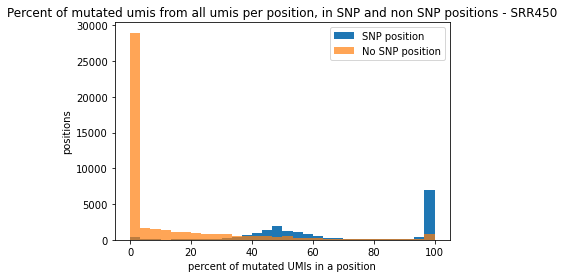

In [18]:
plt.hist(SRR450_df.loc[SRR450_df['is_snp'] >= 1,:]['percent of non ref total umis'],bins=30)
plt.hist(SRR450_df.loc[SRR450_df['is_snp'] == 0,:]['percent of non ref total umis'],bins=30, alpha=.7)
plt.title("Percent of mutated umis from all umis per position, in SNP and non SNP positions - SRR450")
plt.legend(['SNP position', 'No SNP position'])
plt.xlabel("percent of mutated UMIs in a position")
plt.ylabel("positions")
plt.show()

## Show overlap between smaples

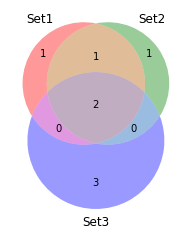

In [19]:
from matplotlib_venn import venn3

set1 = set(['A', 'B', 'C', 'D'])
set2 = set(['B', 'C', 'D', 'E'])
set3 = set(['C', 'D',' E', 'F', 'G'])

venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))
plt.show()

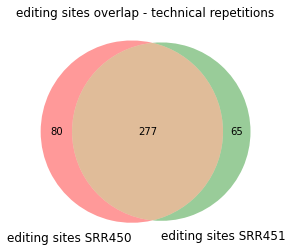

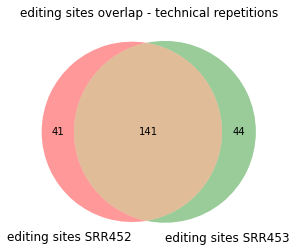

In [20]:
from matplotlib_venn import venn2

#find number of overlaps
overlaps = set(df_edit_450['position']) & set(df_edit_451['position'])

#create Venn diagram
venn2(subsets = (len(df_edit_450['position']) - len(overlaps), len(df_edit_451['position']) - len(overlaps), len(overlaps)),
      set_labels = ('editing sites SRR450', 'editing sites SRR451'))

plt.title("editing sites overlap - technical repetitions")
plt.savefig("technical_repeats_editing_overlaps.png")
plt.show()

#find number of overlaps
overlaps = set(df_edit_452['position']) & set(df_edit_453['position'])

#create Venn diagram
venn2(subsets = (len(df_edit_452['position']) - len(overlaps), len(df_edit_453['position']) - len(overlaps), len(overlaps)),
      set_labels = ('editing sites SRR452', 'editing sites SRR453'))

plt.title("editing sites overlap - technical repetitions")
plt.savefig("technical_repeats_editing_overlaps.png")
plt.show()

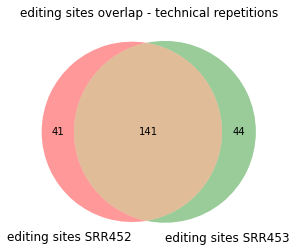

In [21]:
#find number of overlaps
overlaps = set(df_edit_452['position']) & set(df_edit_453['position'])

#create Venn diagram
vd = venn2(subsets = (len(df_edit_452['position']) - len(overlaps), len(df_edit_453['position']) - len(overlaps), len(overlaps)),
      set_labels = ('editing sites SRR452', 'editing sites SRR453'))

plt.title("editing sites overlap - technical repetitions")


# x = vd.get_label_by_id("100")
# vd.get_label_by_id("100").set_x(1.55)
plt.show()

## Chromosomes with most editing sites

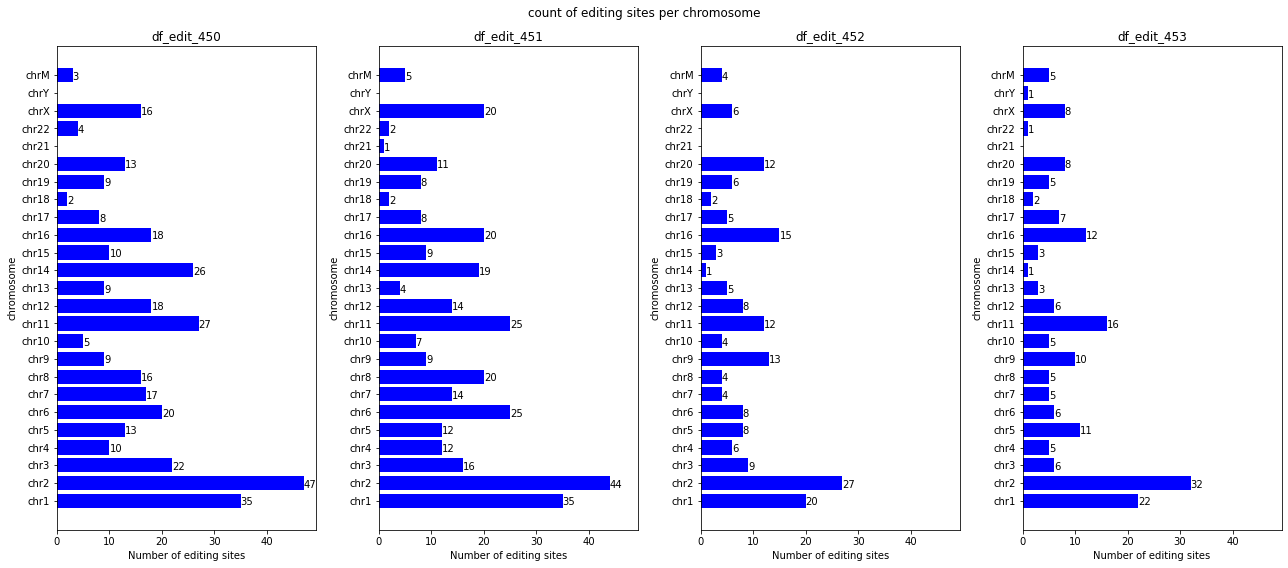

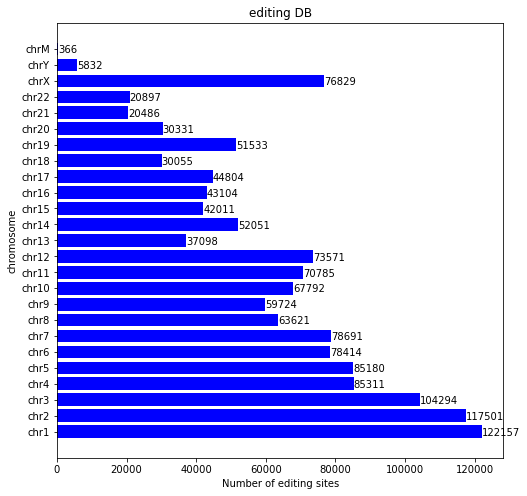

In [59]:
fig, ax = plt.subplots(nrows=1, ncols = 4, sharex=True, sharey=False, figsize=(18,8))

chr_labels = ['chr1', 'chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13',
              'chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX','chrY','chrM']

chr_series = df_edit_450['position'].map(lambda x: x.split(':')[0]).value_counts()
ax[0].barh(range(0,len(chr_labels)), pd.Series(chr_series,index=chr_labels), tick_label=chr_labels, color = 'b')
for i, v in enumerate(pd.Series(chr_series,index=chr_labels).values):
    try:
        ax[0].text(v, i - 0.25, str(int(v)))
    except:
        continue    
ax[0].set_title("df_edit_450")
ax[0].set_ylabel("chromosome")
ax[0].set_xlabel("Number of editing sites")

chr_series = df_edit_451['position'].map(lambda x: x.split(':')[0]).value_counts()
ax[1].barh(range(0,len(chr_labels)), pd.Series(chr_series,index=chr_labels), tick_label=chr_labels, color = 'b')
for i, v in enumerate(pd.Series(chr_series,index=chr_labels).values):
    try:
        ax[1].text(v, i - 0.25, str(int(v)))
    except:
        continue
ax[1].set_title("df_edit_451")
ax[1].set_ylabel("chromosome")
ax[1].set_xlabel("Number of editing sites")
ax[1].yaxis.set_tick_params(labelbottom=True)

chr_series = df_edit_452['position'].map(lambda x: x.split(':')[0]).value_counts()
ax[2].barh(range(0,len(chr_labels)), pd.Series(chr_series,index=chr_labels), tick_label=chr_labels, color = 'b')
for i, v in enumerate(pd.Series(chr_series,index=chr_labels).values):
    try:
        ax[2].text(v, i - 0.25, str(int(v)))
    except:
        continue
ax[2].set_title("df_edit_452")
ax[2].set_ylabel("chromosome")        
ax[2].set_xlabel("Number of editing sites")
ax[2].yaxis.set_tick_params(labelbottom=True)

chr_series = df_edit_453['position'].map(lambda x: x.split(':')[0]).value_counts()
ax[3].barh(range(0,len(chr_labels)), pd.Series(chr_series,index=chr_labels), tick_label=chr_labels, color = 'b')
for i, v in enumerate(pd.Series(chr_series,index=chr_labels).values):
    try:
        ax[3].text(v, i - 0.25, str(int(v)))
    except:
        continue
ax[3].set_title("df_edit_453")
ax[3].set_ylabel("chromosome")        
ax[3].set_xlabel("Number of editing sites")
ax[3].yaxis.set_tick_params(labelbottom=True)

fig.suptitle("count of editing sites per chromosome")
plt.tight_layout()
plt.savefig("editing_sites_per_chromosome.png")
plt.show()


# plot the distribution in the editing database
with open("/home/eligol/Documents/01_WIS/scrarevar/data/DB_edit_snp/human/edit_rep.bed", 'r') as f:
    text = f.readlines()
with open("/home/eligol/Documents/01_WIS/scrarevar/data/DB_edit_snp/human/edit_nonrep.bed", 'r') as f:
    text += f.readlines()
text = text[1:]

plt.figure(figsize=(8,8))
chr_series = pd.Series([l.split('\t')[0] for l in text]).value_counts()
plt.barh(range(0,len(chr_labels)), pd.Series(chr_series,index=chr_labels), tick_label=chr_labels, color = 'b')
for i, v in enumerate(pd.Series(chr_series,index=chr_labels).values):
    try:
        plt.text(v, i - 0.25, str(int(v)))
    except:
        continue
    
plt.title("editing DB")
plt.ylabel("chromosome") 
plt.xlabel("Number of editing sites")
plt.show()

### Number of editing sites per cell

9338 mutations compattable with known editing sites in 
4050 cells out of total number of 
6959 cells in sample


8975 mutations compattable with known editing sites in 
4004 cells out of total number of 
6958 cells in sample


4757 mutations in known editing sites in 
2714 cells out of total number of 
6421 cells in sample


4606 mutations in known editing sites in 
2709 cells out of total number of 
6448 cells in sample




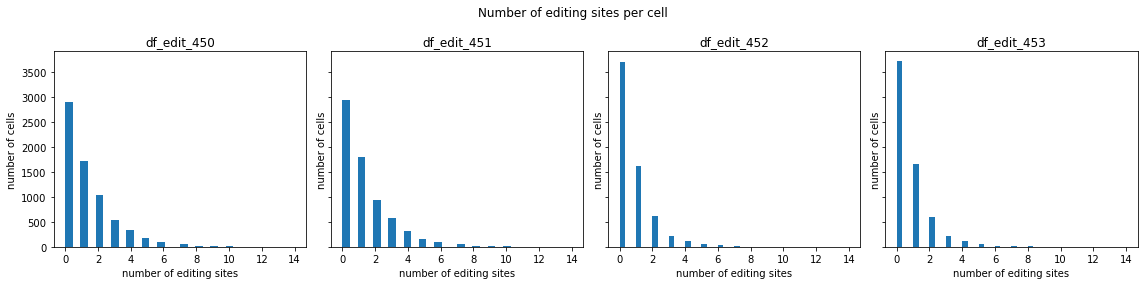

In [23]:
fig, ax = plt.subplots(nrows=1, ncols = 4, sharex=True, sharey=True, figsize=(16,4))


editings_per_cb_SRR450 = df_open_SRR450.iloc[:,:].groupby('cell barcode')['is_edit'].sum()
print("{} mutations compattable with known editing sites in \n{} cells out of total number of \n{} cells in sample\n\n".format(df_open_SRR450[df_open_SRR450['is_edit'] == 1].shape[0], (editings_per_cb_SRR450 > 0).sum(), df_open_SRR450['cell barcode'].nunique()))
ax[0].hist(editings_per_cb_SRR450, bins = 30)
ax[0].set_title("df_edit_450")
ax[0].set_ylabel("number of cells")
ax[0].set_xlabel("number of editing sites")

editings_per_cb_SRR451 = df_open_SRR451.iloc[:,:].groupby('cell barcode')['is_edit'].sum()
print("{} mutations compattable with known editing sites in \n{} cells out of total number of \n{} cells in sample\n\n".format(df_open_SRR451[df_open_SRR451['is_edit'] == 1].shape[0], (editings_per_cb_SRR451 > 0).sum(), df_open_SRR451['cell barcode'].nunique()))
ax[1].hist(editings_per_cb_SRR451, bins = 30)
ax[1].set_title("df_edit_451")
ax[1].set_ylabel("number of cells")
ax[1].set_xlabel("number of editing sites")

editings_per_cb_SRR452 = df_open_SRR452.iloc[:,:].groupby('cell barcode')['is_edit'].sum()
print("{} mutations in known editing sites in \n{} cells out of total number of \n{} cells in sample\n\n".format(df_open_SRR452[df_open_SRR452['is_edit'] == 1].shape[0], (editings_per_cb_SRR452 > 0).sum(), df_open_SRR452['cell barcode'].nunique()))
ax[2].hist(editings_per_cb_SRR452, bins = 30)
ax[2].set_title("df_edit_452")
ax[2].set_ylabel("number of cells")
ax[2].set_xlabel("number of editing sites")


editings_per_cb_SRR453 = df_open_SRR453.iloc[:,:].groupby('cell barcode')['is_edit'].sum()
print("{} mutations in known editing sites in \n{} cells out of total number of \n{} cells in sample\n\n".format(df_open_SRR453[df_open_SRR453['is_edit'] == 1].shape[0], (editings_per_cb_SRR453 > 0).sum(), df_open_SRR453['cell barcode'].nunique()))
ax[3].hist(editings_per_cb_SRR453, bins = 30)
ax[3].set_title("df_edit_453")
ax[3].set_ylabel("number of cells")
ax[3].set_xlabel("number of editing sites")

fig.suptitle("Number of editing sites per cell")
plt.tight_layout()
plt.savefig("editing_sites_per_cell.png")
plt.show()

# HEATMAPS

In [24]:
df_open_edit_SRR450

chromosome     start       end        cell barcode  percent of non ref  \
0         chr10  11177200  11177201  ACATACGCAATGAAAC-1                 100   
1         chr10  11177200  11177201  TTAGGCAAGGGTCGAT-1                 100   
2         chr10  11177200  11177201  CGTGTCTCACCGAAAG-1                 100   
3         chr10  11177200  11177201  GGACAAGCAAGCGATG-1                 100   
4         chr10  11177200  11177201  GCAATCAAGATGCCTT-1                 100   
...         ...       ...       ...                 ...                 ...   
9333       chrX  78126159  78126160  ATCATGGTCGCAAGCC-1                 100   
9334       chrX  78126159  78126160  CGTTGGGCAATGAATG-1                  50   
9335       chrX  78126159  78126160  CGAACATCAAGCCGTC-1                 100   
9336       chrX  78126159  78126160  TCTGAGAAGTACGTAA-1                  50   
9337       chrX  78126159  78126160  TAAACCGCAGTAGAGC-1                  33   

     strand reference base  same multi reads  transition multi reads  \
0         +              a                 0                       1   
1         +              a                 0                       1   
2         +              a                 0                       0   
3         +              a                 0                       1   
4         +              a                 0                       1   
...     ...            ...               ...                     ...   
9333      +              t                 0                       0   
9334      +              t                 0                       0   
9335      +              t                 0                       0   
9336      +              t                 1                       1   
9337      +              t                 0                       0   

      reverse multi reads  transvertion multi reads  same single reads  \
0                       0                         0                  0   
1                       0                         0                  0   
2                       0                         0                  0   
3                       0                         0                  0   
4                       0                         0                  0   
...                   ...                       ...                ...   
9333                    0                         0                  0   
9334                    0                         0                  1   
9335                    0                         0                  0   
9336                    0                         0                  0   
9337                    0                         0                  2   

      transition single reads  reverse single reads  \
0                           0                     0   
1                           0                     0   
2                           1                     0   
3                           0                     0   
4                           0                     0   
...                       ...                   ...   
9333                        1                     0   
9334                        1                     0   
9335                        0                     0   
9336                        0                     0   
9337                        1                     0   

      transvertion single reads  mixed reads                   position  \
0                             0            0  chr10:11177200-11177201,+   
1                             0            0  chr10:11177200-11177201,+   
2                             0            0  chr10:11177200-11177201,+   
3                             0            0  chr10:11177200-11177201,+   
4                             0            0  chr10:11177200-11177201,+   
...                         ...          ...                        ...   
9333                          0            0   chrX:78126159-78126160,+   
9334                          0          

In [25]:
# create heatmap for Cells VS. Positions
cells_VS_position_umis_SRR450 = df_open_edit_SRR450.pivot(index = 'cluster cell barcode', columns = 'position', values = "mutated umis per cell")
cells_VS_position_umis_SRR451 = df_open_edit_SRR451.pivot(index = 'cluster cell barcode', columns = 'position', values = "mutated umis per cell")
cells_VS_position_umis_SRR452 = df_open_edit_SRR452.pivot(index = 'cluster cell barcode', columns = 'position', values = "mutated umis per cell")
cells_VS_position_umis_SRR453 = df_open_edit_SRR453.pivot(index = 'cluster cell barcode', columns = 'position', values = "mutated umis per cell")

# create heatmap for Cells VS. Genes
cells_VS_genes_umis_SRR450 = df_open_edit_SRR450.groupby(['gene_name','cluster cell barcode']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "mutated umis per cell")
cells_VS_genes_umis_SRR451 = df_open_edit_SRR451.groupby(['gene_name','cluster cell barcode']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "mutated umis per cell")
cells_VS_genes_umis_SRR452 = df_open_edit_SRR452.groupby(['gene_name','cluster cell barcode']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "mutated umis per cell")
cells_VS_genes_umis_SRR453 = df_open_edit_SRR453.groupby(['gene_name','cluster cell barcode']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "mutated umis per cell")

# create heatmap for Seurat clusters VS. Genes
clusters_VS_genes_umis_SRR450 = df_open_edit_SRR450.groupby(['cluster','gene_name']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "mutated umis per cell")
clusters_VS_genes_umis_SRR451 = df_open_edit_SRR451.groupby(['cluster','gene_name']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "mutated umis per cell")
clusters_VS_genes_umis_SRR452 = df_open_edit_SRR452.groupby(['cluster','gene_name']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "mutated umis per cell")
clusters_VS_genes_umis_SRR453 = df_open_edit_SRR453.groupby(['cluster','gene_name']).agg({'mutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "mutated umis per cell")



# create heatmap for Cells VS. Positions - unmutated umis
cells_VS_position_unmutated_umis_SRR450 = df_open_edit_SRR450.pivot(index = 'cluster cell barcode', columns = 'position', values = "unmutated umis per cell")
cells_VS_position_unmutated_umis_SRR451 = df_open_edit_SRR451.pivot(index = 'cluster cell barcode', columns = 'position', values = "unmutated umis per cell")
cells_VS_position_unmutated_umis_SRR452 = df_open_edit_SRR452.pivot(index = 'cluster cell barcode', columns = 'position', values = "unmutated umis per cell")
cells_VS_position_unmutated_umis_SRR453 = df_open_edit_SRR453.pivot(index = 'cluster cell barcode', columns = 'position', values = "unmutated umis per cell")

# create heatmap for Cells VS. Genes- unmutated umis
cells_VS_genes_unmutated_umis_SRR450 = df_open_edit_SRR450.groupby(['gene_name','cluster cell barcode']).agg({'unmutated umis per cell': 'first'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "unmutated umis per cell")
cells_VS_genes_unmutated_umis_SRR451 = df_open_edit_SRR451.groupby(['gene_name','cluster cell barcode']).agg({'unmutated umis per cell': 'first'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "unmutated umis per cell")
cells_VS_genes_unmutated_umis_SRR452 = df_open_edit_SRR452.groupby(['gene_name','cluster cell barcode']).agg({'unmutated umis per cell': 'first'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "unmutated umis per cell")
cells_VS_genes_unmutated_umis_SRR453 = df_open_edit_SRR453.groupby(['gene_name','cluster cell barcode']).agg({'unmutated umis per cell': 'first'}).reset_index().pivot(index = 'cluster cell barcode', columns = 'gene_name', values = "unmutated umis per cell")

# create heatmap for Seurat clusters VS. Genes - unmutated umis
clusters_VS_genes_unmutated_umis_SRR450 = df_open_edit_SRR450.groupby(['cluster','gene_name','position']).agg({'unmutated umis per cell': 'first'}).groupby(['cluster','gene_name']).agg({'unmutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "unmutated umis per cell")
clusters_VS_genes_unmutated_umis_SRR451 = df_open_edit_SRR451.groupby(['cluster','gene_name','position']).agg({'unmutated umis per cell': 'first'}).groupby(['cluster','gene_name']).agg({'unmutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "unmutated umis per cell")
clusters_VS_genes_unmutated_umis_SRR452 = df_open_edit_SRR452.groupby(['cluster','gene_name','position']).agg({'unmutated umis per cell': 'first'}).groupby(['cluster','gene_name']).agg({'unmutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "unmutated umis per cell")
clusters_VS_genes_unmutated_umis_SRR453 = df_open_edit_SRR453.groupby(['cluster','gene_name','position']).agg({'unmutated umis per cell': 'first'}).groupby(['cluster','gene_name']).agg({'unmutated umis per cell': 'sum'}).reset_index().pivot(index = 'cluster', columns = 'gene_name', values = "unmutated umis per cell")




# create a dictionary between chromosomes and genes
chr_genes_pairs = pd.concat([df_open_edit_SRR452.loc[:, ['chromosome','gene_name']],df_open_edit_SRR453.loc[:, ['chromosome','gene_name']], df_open_edit_SRR450.loc[:, ['chromosome','gene_name']], df_open_edit_SRR451.loc[:, ['chromosome','gene_name']]])
chr_genes_pairs = pd.Series(chr_genes_pairs.chromosome.values, index=chr_genes_pairs.gene_name).to_dict()

In [26]:
# fill the missing values with 0
cells_VS_genes_umis_SRR450_0 = cells_VS_genes_umis_SRR450.fillna(0)
# convert all UMI counts to 1, so we can count each cell/gene one time
cells_VS_genes_umis_SRR450_0[cells_VS_genes_umis_SRR450_0>1] = 1
# get indices of cells which occures im more than 1 gene
cells_idx = cells_VS_genes_umis_SRR450_0[cells_VS_genes_umis_SRR450_0.sum(axis=1) > 1].index  # choose the mutated cells with which occurse more than one time in all the genes
# show the number of mutated UMIs in each of these cells
repetitive_cells_VS_genes_umis_SRR450 = cells_VS_genes_umis_SRR450.loc[cells_idx]
repetitive_cells_VS_genes_umis_SRR450


gene_name              ABCD4  ABHD18  AC004980.1  AC025165.2  AC079140.2  \
cluster cell barcode                                                       
c0_AAACGGGCACCATGTA-1    NaN     NaN         NaN         NaN         NaN   
c0_AAACGGGCATCTCGCT-1    NaN     NaN         NaN         NaN         NaN   
c0_AAAGCAATCGAATGCT-1    NaN     NaN         NaN         NaN         NaN   
c0_AAATGCCTCCATGAGT-1    NaN     NaN         NaN         NaN         NaN   
c0_AACCATGTCTCAAGTG-1    NaN     NaN         NaN         NaN         NaN   
...                      ...     ...         ...         ...         ...   
c9_TTAGTTCAGCCTATGT-1    NaN     NaN         NaN         NaN         NaN   
c9_TTATGCTAGAAACGCC-1    NaN     NaN         NaN         NaN         NaN   
c9_TTCTCCTTCTTGCATT-1    NaN     NaN         NaN         NaN         NaN   
c9_TTTCCTCCAGCCTTTC-1    NaN     NaN         NaN         NaN         1.0   
c9_TTTGCGCTCGCCAGCA-1    NaN     NaN         NaN         NaN         NaN   

gene_name              AC087283.1  AC092691.1  AC114760.2  AC132008.2  ACVR2A  \
cluster cell barcode                                                            
c0_AAACGGGCACCATGTA-1         NaN         NaN         NaN         NaN     NaN   
c0_AAACGGGCATCTCGCT-1         NaN         NaN         NaN         NaN     NaN   
c0_AAAGCAATCGAATGCT-1         NaN         NaN         NaN         NaN     NaN   
c0_AAATGCCTCCATGAGT-1         NaN         NaN         NaN         NaN     NaN   
c0_AACCATGTCTCAAGTG-1         NaN         NaN         NaN         NaN     NaN   
...                           ...         ...         ...         ...     ...   
c9_TTAGTTCAGCCTATGT-1         NaN         NaN         NaN         NaN     NaN   
c9_TTATGCTAGAAACGCC-1         NaN         NaN         NaN         NaN     NaN   
c9_TTCTCCTTCTTGCATT-1         NaN         NaN         NaN         NaN     NaN   
c9_TTTCCTCCAGCCTTTC-1         NaN         NaN         NaN         NaN     NaN   
c9_TTTGCGCTCGCCAGCA-1         NaN         NaN         NaN         NaN     NaN   

gene_name              ADGRB3  ADNP  AL050309.1  AL513365.1  AL591846.1  \
cluster cell barcode                                                      
c0_AAACGGGCACCATGTA-1     NaN   NaN         NaN         NaN         1.0   
c0_AAACGGGCATCTCGCT-1     NaN   NaN         NaN         NaN         NaN   
c0_AAAGCAATCGAATGCT-1     NaN   NaN         NaN         NaN         NaN   
c0_AAATGCCTCCATGAGT-1     NaN   NaN         NaN         NaN         NaN   
c0_AACCATGTCTCAAGTG-1     NaN   NaN         NaN         NaN         NaN   
...                       ...   ...         ...         ...         ...   
c9_TTAGTTCAGCCTATGT-1     NaN   NaN         NaN         1.0         NaN   
c9_TTATGCTAGAAACGCC-1     NaN   NaN         NaN         NaN         NaN   
c9_TTCTCCTTCTTGCATT-1     NaN   NaN         NaN         1.0         NaN   
c9_TTTCCTCCAGCCTTTC-1     NaN   NaN         NaN         NaN         NaN   
c9_TTTGCGCTCGCCAGCA-1     NaN   NaN         NaN         NaN         NaN   

gene_name              ALMS1  ANKIB1  ANKRD13C  ANO10  AP002989.1  APC  ARG2  \
cluster cell barcode                                                           
c0_AAACGGGCACCATGTA-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c0_AAACGGGCATCTCGCT-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c0_AAAGCAATCGAATGCT-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c0_AAATGCCTCCATGAGT-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c0_AACCATGTCTCAAGTG-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
...                      ...     ...       ...    ...         ...  ...   ...   
c9_TTAGTTCAGCCTATGT-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c9_TTATGCTAGAAACGCC-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c9_TTCTCCTTCTTGCATT-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c9_TTTCCTCCAGCCTTTC-1    NaN     NaN       NaN    NaN         NaN  NaN   NaN   
c9_TTTGCGCTCGCCAGCA-1

In [27]:
t = cells_VS_genes_umis_SRR450_0 @ cells_VS_genes_umis_SRR450_0.T
np.fill_diagonal(t.values, 0)
t

cluster cell barcode   c0_AAACGGGCAAAGGTGC-1  c0_AAACGGGCAAGCTGGA-1  \
cluster cell barcode                                                  
c0_AAACGGGCAAAGGTGC-1                    0.0                    0.0   
c0_AAACGGGCAAGCTGGA-1                    0.0                    0.0   
c0_AAACGGGCACCATGTA-1                    0.0                    0.0   
c0_AAACGGGCATCTCGCT-1                    0.0                    0.0   
c0_AAACGGGTCTTTCCTC-1                    0.0                    0.0   
...                                      ...                    ...   
c9_TTGGCAATCCTTTCTC-1                    0.0                    0.0   
c9_TTGTAGGAGAGTTGGC-1                    0.0                    0.0   
c9_TTTCCTCCAGCCTTTC-1                    0.0                    0.0   
c9_TTTGCGCCATCCAACA-1                    0.0                    0.0   
c9_TTTGCGCTCGCCAGCA-1                    0.0                    0.0   

cluster cell barcode   c0_AAACGGGCACCATGTA-1  c0_AAACGGGCATCTCGCT-1  \
cluster cell barcode                                                  
c0_AAACGGGCAAAGGTGC-1                    0.0                    0.0   
c0_AAACGGGCAAGCTGGA-1                    0.0                    0.0   
c0_AAACGGGCACCATGTA-1                    0.0                    0.0   
c0_AAACGGGCATCTCGCT-1                    0.0                    0.0   
c0_AAACGGGTCTTTCCTC-1                    0.0                    0.0   
...                                      ...                    ...   
c9_TTGGCAATCCTTTCTC-1                    0.0                    0.0   
c9_TTGTAGGAGAGTTGGC-1                    0.0                    0.0   
c9_TTTCCTCCAGCCTTTC-1                    0.0                    0.0   
c9_TTTGCGCCATCCAACA-1                    0.0                    0.0   
c9_TTTGCGCTCGCCAGCA-1                    0.0                    0.0   

cluster cell barcode   c0_AAACGGGTCTTTCCTC-1  c0_AAAGCAAGTAGGACAC-1  \
cluster cell barcode                                                  
c0_AAACGGGCAAAGGTGC-1                    0.0                    0.0   
c0_AAACGGGCAAGCTGGA-1                    0.0                    0.0   
c0_AAACGGGCACCATGTA-1                    0.0                    0.0   
c0_AAACGGGCATCTCGCT-1                    0.0                    0.0   
c0_AAACGGGTCTTTCCTC-1                    0.0                    0.0   
...                                      ...                    ...   
c9_TTGGCAATCCTTTCTC-1                    0.0                    0.0   
c9_TTGTAGGAGAGTTGGC-1                    0.0                    0.0   
c9_TTTCCTCCAGCCTTTC-1                    0.0                    0.0   
c9_TTTGCGCCATCCAACA-1                    0.0                    0.0   
c9_TTTGCGCTCGCCAGCA-1                    0.0                    0.0   

cluster cell barcode   c0_AAAGCAATCACATACG-1  c0_AAAGCAATCGAATGCT-1  \
cluster cell barcode                                                  
c0_AAACGGGCAAAGGTGC-1                    0.0                    0.0   
c0_AAACGGGCAAGCTGGA-1                    0.0                    0.0   
c0_AAACGGGCACCATGTA-1                    0.0                    0.0   
c0_AAACGGGCATCTCGCT-1                    0.0                    0.0   
c0_AAACGGGTCTTTCCTC-1                    0.0                    0.0   
...                                      ...                    ...   
c9_TTGGCAATCCTTTCTC-1                    0.0                    0.0   
c9_TTGTAGGAGAGTTGGC-1                    0.0                    0.0   
c9_TTTCCTCCAGCCTTTC-1                    0.0                    0.0   
c9_TTTGCGCCATCCAACA-1                    0.0                    0.0   
c9_TTTGCGCTCGCCAGCA-1                    0.0                    0.0   

cluster cell barcode   c0_AAAGTAGCACGAGGTA-1  c0_AAATGCCTCCATGAGT-1  \
cluster cell barcode                                                  
c0_AAACGGGCAAAGGTGC-1                    0.0                    0.0   
c0_AAACGGGCAAGCTGGA-1                    0.0                    0.0   
c0_AAACGGGCACCATGTA-

In [17]:
clusters_VS_genes_umis_SRR452.head(3)

gene_name  AC079140.2  AC087283.1  AC114760.2  AC132008.2  ACAT2  ADGRB3  \
cluster                                                                    
c0               39.0         1.0         NaN         7.0    3.0     1.0   
c1               29.0         3.0         NaN         4.0    2.0     1.0   
c10              18.0         1.0         NaN         5.0    NaN     NaN   

gene_name  ADNP  AL513365.1  ANKIB1  ANKRD13C  ARG2  BTAF1  C11orf49  CCDC65  \
cluster                                                                        
c0         16.0        15.0     3.0       5.0   2.0    2.0      14.0     2.0   
c1          6.0        19.0     NaN       NaN   NaN    NaN      16.0     1.0   
c10         2.0        15.0     2.0       NaN   NaN    NaN      10.0     NaN   

gene_name  CFDP1  CIRBP  CLASP2  CNOT7  CNST  CTNNA2  CYRIA  DANT2  DCC  \
cluster                                                                   
c0           3.0    1.0     4.0    2.0   2.0    69.0    1.0    NaN  7.0   
c1           1.0    NaN     NaN    NaN   1.0     1.0    NaN    1.0  NaN   
c10          NaN    NaN     NaN    2.0   NaN     8.0    NaN    1.0  NaN   

gene_name  DHCR24  DLGAP4  ESD  FAM135A  FBXL7  FRG1BP  FTX  GIGYF2  GPC6  \
cluster                                                                     
c0            5.0     8.0  6.0      2.0    3.0     3.0  5.0     NaN   1.0   
c1            4.0     2.0  1.0      3.0   17.0     4.0  1.0     2.0   NaN   
c10           2.0     1.0  3.0      NaN    6.0     1.0  1.0     2.0   NaN   

gene_name  GRIA1  GRIP1  H2BC6  HDAC9  ILF2  ITFG1  KAZN  KCNH7  KLHL23  \
cluster                                                                   
c0           2.0    1.0    4.0    6.0   3.0    3.0   NaN   13.0     2.0   
c1           NaN    1.0    1.0   10.0   1.0    4.0   NaN    NaN     3.0   
c10          NaN    NaN    2.0    NaN   3.0    1.0   1.0   10.0     2.0   

gene_name  MALAT1  MAP1B  MCRIP1  MDM2  MT-CO3  MT-CYB  MT-ND4  MTATP6P1  \
cluster                                                                    
c0            1.0    2.0    23.0   6.0     2.0     2.0     3.0       1.0   
c1            2.0    NaN    11.0   2.0     1.0     NaN     3.0       1.0   
c10           2.0    NaN     5.0   2.0     NaN     NaN     2.0       1.0   

gene_name  NACA3P  NEGR1  NHP2  OLA1  PDE1A  PGK1  PRDX1  PSME3IP1  PTPRD  \
cluster                                                                     
c0            5.0    7.0   1.0   1.0    4.0   2.0    1.0      11.0   14.0   
c1            7.0   10.0   1.0   1.0    NaN   2.0    1.0       5.0    1.0   
c10           NaN    9.0   2.0   1.0    1.0   NaN    NaN       4.0    2.0   

gene_name  RBBP4  RBFOX1  RBM3  RHOA  RMI1  RNPS1  RPAIN  RPL10P16  RPL13P12  \
cluster                                                                        
c0           6.0    16.0  10.0   NaN   NaN    2.0    3.0      35.0       5.0   
c1           3.0     NaN   5.0   NaN   5.0    NaN    NaN      16.0       3.0   
c10          2.0     1.0   2.0   NaN   NaN    NaN    2.0       6.0       1.0   

gene_name  RPL24  RPL36  RPL5  RPLP1  RPS23  RPS28  RPS7P10  SEC61A1  \
cluster                                                                
c0           2.0    5.0   2.0    NaN    4.0    1.0      3.0     20.0   
c1           2.0    2.0   3.0    3.0    2.0    4.0      NaN      6.0   
c10          1.0    1.0   2.0    1.0    3.0    NaN      2.0      4.0   

gene_name  SH3BGRL3  SHROOM3  SLC2A3  SLC39A6  STAP2  STX2  TASOR2  TCP1  \
cluster                                                                    
c0              1.0      NaN     4.0     14.0    NaN   1.0     3.0   NaN   
c1              3.0     11.0     8.0      3.0    3.0   NaN     NaN   1.0   
c10             3.0      2.0     3.0      4.0    NaN   NaN     1.0   NaN   

gene_name  TMEM223  TNKS  TRAF3IP2-AS1  TRIM13  TRUB2  TTC21B   UBC  UGGT2  \
cluster                                                                      
c0            

## Clustering heatmap 

In [32]:
from matplotlib import cm

def make_clusters_heatmap(df_cb_position_umis, name, min_umi_per_position, min_umi_per_cell):
    # filter rows (positions) and columns (cells)
    df_temp = df_cb_position_umis[df_cb_position_umis.sum(axis=1) > min_umi_per_cell] # keep cells with more than N mutated umis
    df_temp = df_temp.loc[:, df_temp.sum(axis=0) > min_umi_per_position]  # keep positions with more than N mutetaed umis
    print("shape of df is:", df_temp.shape)
    
    # define clusters and set color map for rows
#     clusters = df_temp.index.map(lambda x: x.split('_')[0]) # use Seurat clusters
    clusters = df_temp.index # use Seurat clusters
    print("number of colors on X axis:", clusters.nunique())
    gist_rainbow = cm.get_cmap('cool', clusters.nunique())
    clsters_lut = dict(zip(clusters.unique(),gist_rainbow(np.linspace(0, 1, clusters.nunique()))))
    cluster_colors = clusters.map(clsters_lut)
    
    # define gene names and set color map by chromosome
    gist_rainbow = cm.get_cmap('gist_rainbow', len(set(chr_genes_pairs.values())))
    genes_lut = dict(zip(set(chr_genes_pairs.values()),gist_rainbow(np.linspace(0, 1, len(set(chr_genes_pairs.values()))))))
    genes = df_temp.columns
    gene_colors = genes.map(chr_genes_pairs).map(genes_lut)  #map genes to chromosomes and chromosomes to colors

    # , xticklabels=True, yticklabels=True
#     col_colors=cluster_colors,
    cg = sns.clustermap(df_temp.fillna(0).T, metric = 'euclidean',method='complete', row_cluster=True, col_cluster=True, col_colors=cluster_colors,
                        xticklabels=True, yticklabels=True,cmap='rocket_r',figsize = (30,30))
    cg.ax_row_dendrogram.set_visible(True)
    cg.ax_col_dendrogram.set_visible(True)
    
    # color the gene names according to chromosomoes
    for tick, color in zip(cg.ax_heatmap.get_yticklabels(), gene_colors): 
        c = genes_lut[chr_genes_pairs[tick.get_text()]]
        plt.setp(tick, color=c, size=18, x=1, ha='left')
        
    # color the Seurat cluster text
#     for tick, color in zip(cg.ax_heatmap.get_xticklabels(), cluster_colors): 
#         c = clsters_lut[tick.get_text()]
#         plt.setp(tick, color=c, y=1, va='baseline')  # 'va': top', 'bottom', 'center', 'baseline', 'center_baseline'
        
    plt.title("mutation UMI's cell VS position")
    plt.savefig('editing_clusters_Seuratclusters_VS_genes_unmutated_no_filters_{}.png'.format(name))
    plt.show()


### Heatmap - mutation clusters (Seruat clusters VS. Genes)

shape of df is: (1960, 187)
number of colors on X axis: 1960


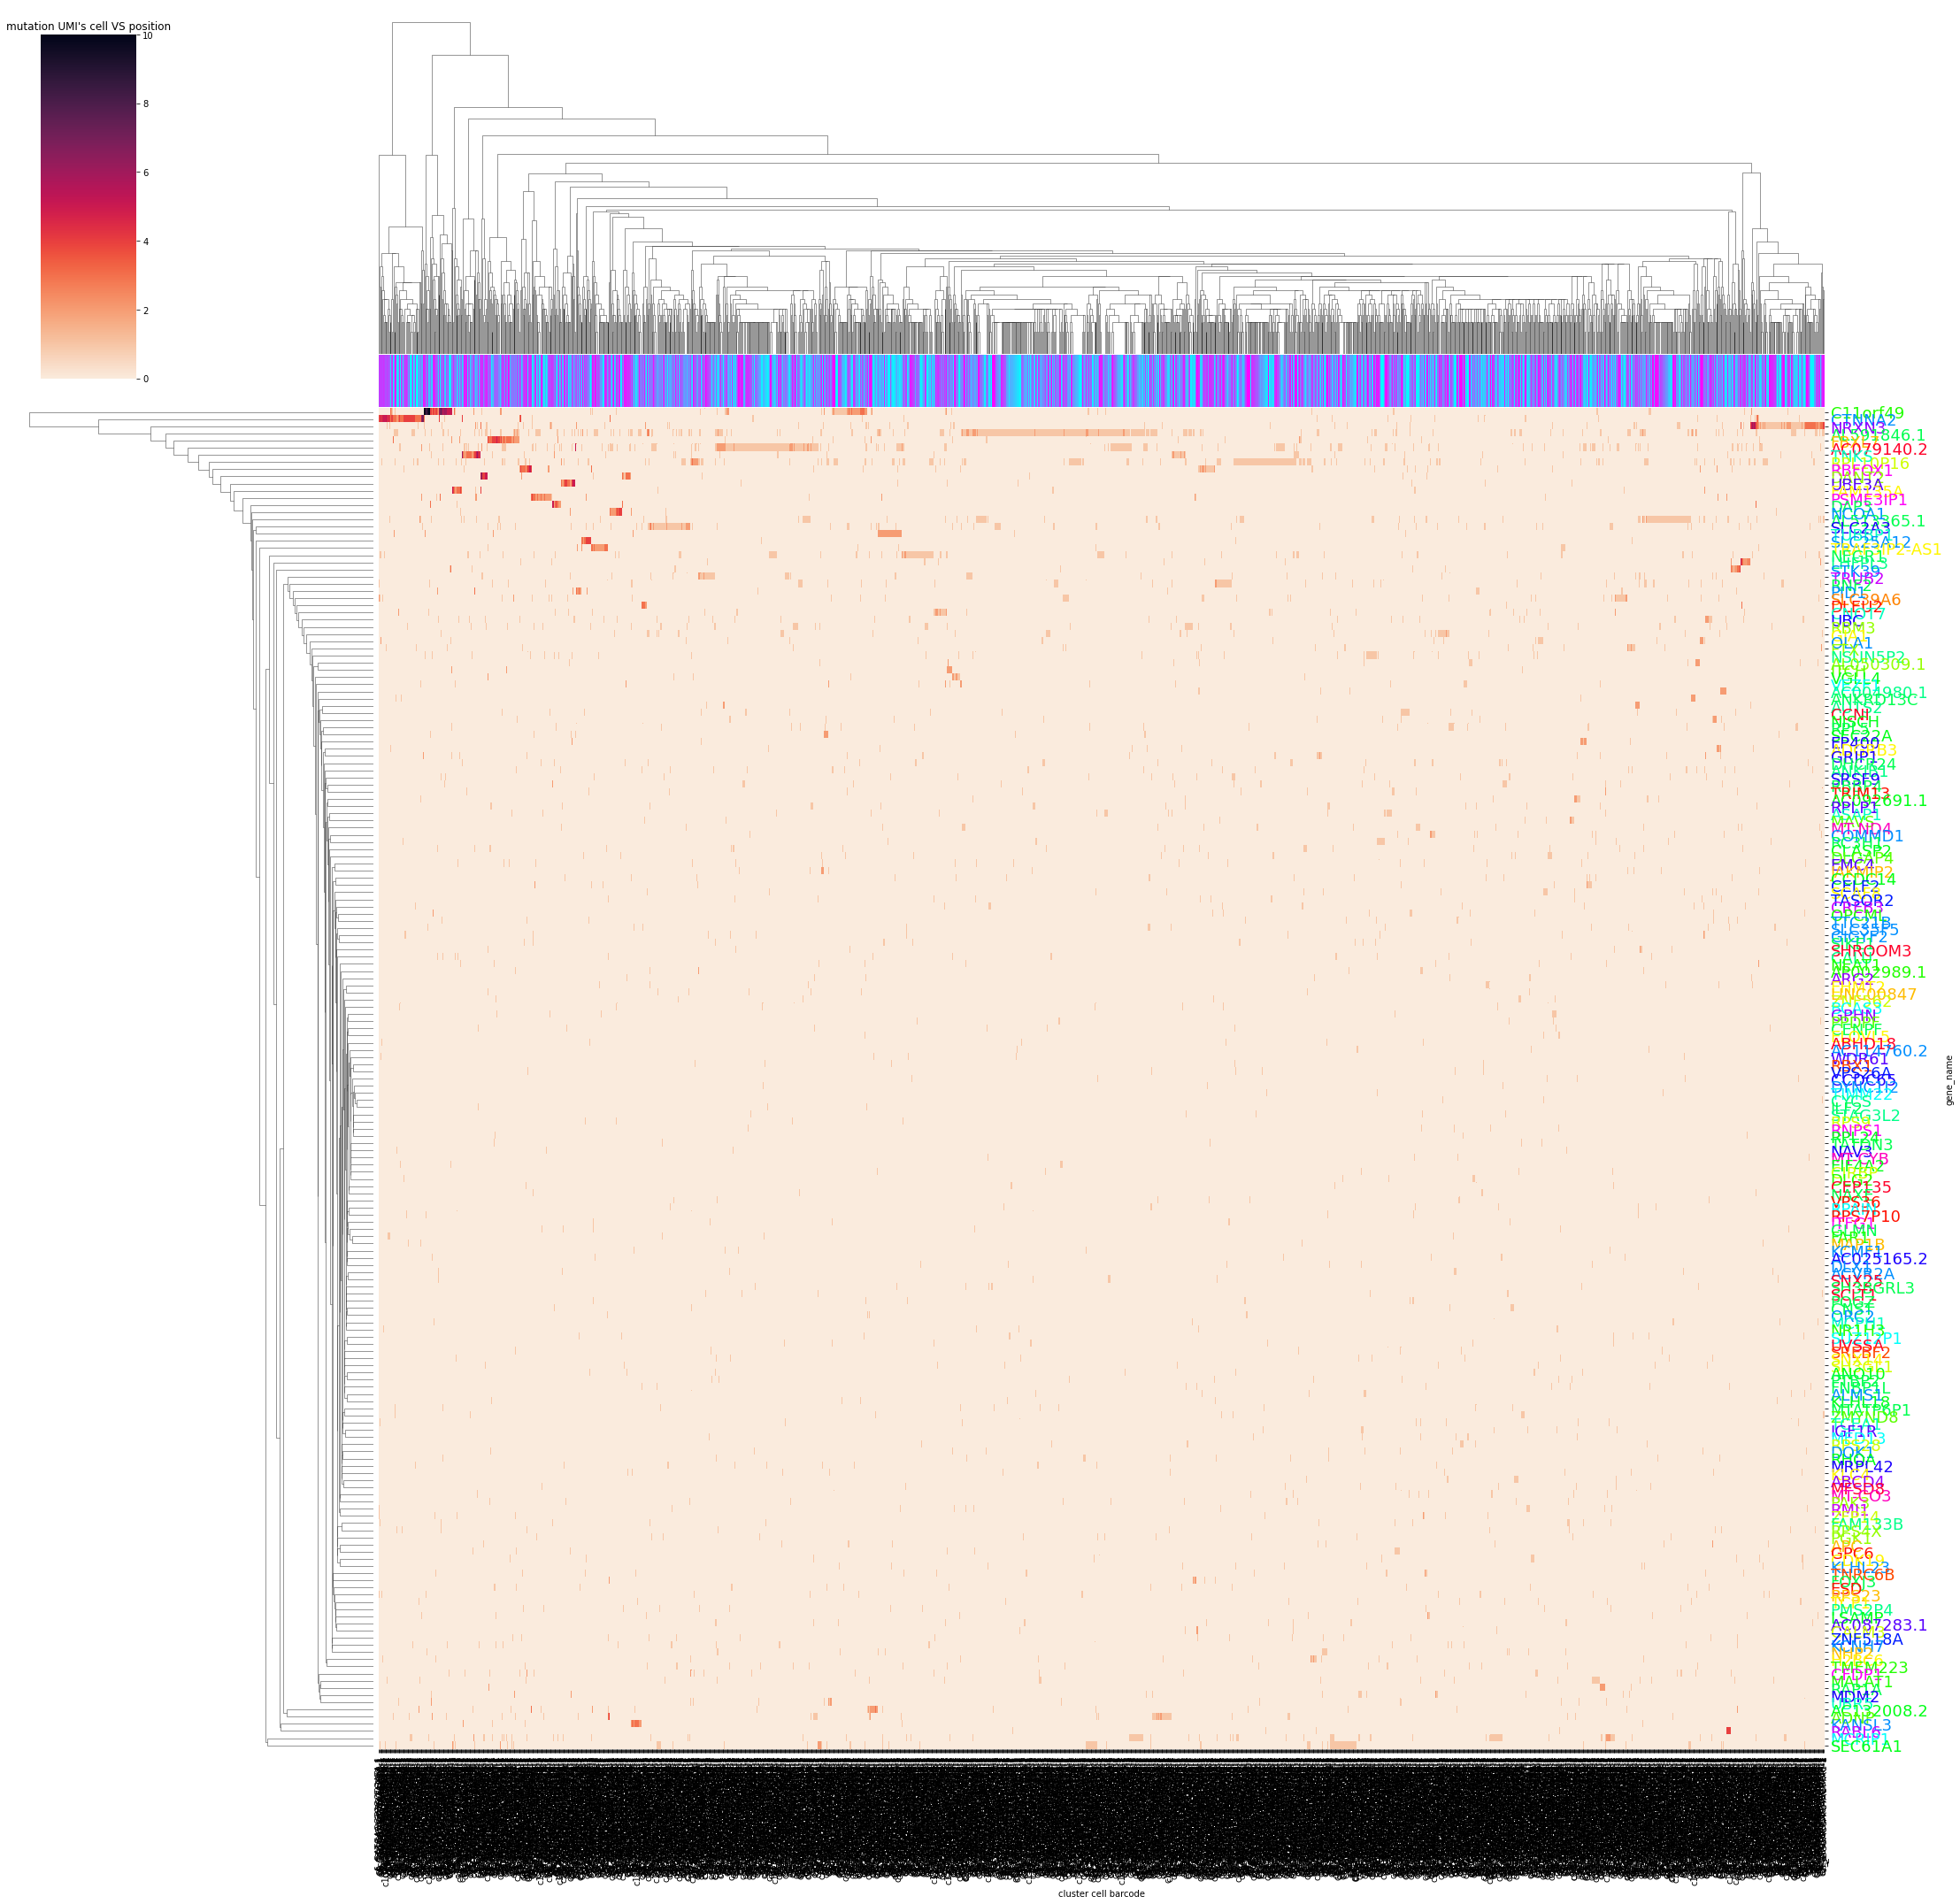

In [33]:
make_clusters_heatmap(repetitive_cells_VS_genes_umis_SRR450, name = 'SRR450', min_umi_per_position=0, min_umi_per_cell=0)

In [ ]:
make_clusters_heatmap(clusters_VS_genes_umis_SRR450, name = 'SRR450', min_umi_per_position=0, min_umi_per_cell=0)

In [ ]:
make_clusters_heatmap(clusters_VS_genes_umis_SRR450, name = 'SRR450', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_umis_SRR451, name = 'SRR451', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_umis_SRR452, name = 'SRR452', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_umis_SRR453, name = 'SRR453', min_umi_per_position=0, min_umi_per_cell=0)

In [ ]:
make_clusters_heatmap(clusters_VS_genes_unmutated_umis_SRR450, name = 'SRR450', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_unmutated_umis_SRR451, name = 'SRR451', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_unmutated_umis_SRR452, name = 'SRR452', min_umi_per_position=0, min_umi_per_cell=0)
make_clusters_heatmap(clusters_VS_genes_unmutated_umis_SRR453, name = 'SRR453', min_umi_per_position=0, min_umi_per_cell=0)

## Heatmap - mutation clusters (Cells VS. Positions)

In [ ]:
# make_clusters_heatmap(cells_VS_position_umis_SRR450, name = 'SRR450', min_umi_per_position=1, min_umi_per_cell=3)
make_clusters_heatmap(cells_VS_position_umis_SRR451, name = 'SRR451', min_umi_per_position=1, min_umi_per_cell=3)
# make_clusters_heatmap(cells_VS_position_umis_SRR452, name = 'SRR452', min_umi_per_position=1, min_umi_per_cell=3)
# make_clusters_heatmap(cells_VS_position_umis_SRR453, name = 'SRR453', min_umi_per_position=1, min_umi_per_cell=3)

In [ ]:
# heatmaps - unmutated umis

make_clusters_heatmap(cells_VS_position_unmutated_umis_SRR450, name = 'SRR450', min_umi_per_position=1, min_umi_per_cell=3)
make_clusters_heatmap(cells_VS_position_unmutated_umis_SRR451, name = 'SRR451', min_umi_per_position=1, min_umi_per_cell=3)
# make_clusters_heatmap(cells_VS_position_unmutated_umis_SRR452, name = 'SRR452', min_umi_per_position=1, min_umi_per_cell=3)
# make_clusters_heatmap(cells_VS_position_unmutated_umis_SRR453, name = 'SRR453', min_umi_per_position=1, min_umi_per_cell=3)

### Heatmap - mutation clusters (cells VS. Genes)

In [222]:
# make_clusters_heatmap(cells_VS_genes_umis_SRR450, name = 'SRR450', min_umi_per_position=0, min_umi_per_cell=0)
# make_clusters_heatmap(cells_VS_genes_umis_SRR452, name = 'SRR452', min_umi_per_position=0, min_umi_per_cell=0)
# make_clusters_heatmap(cells_VS_genes_umis_SRR453, name = 'SRR453', min_umi_per_position=0, min_umi_per_cell=0)

### mutation UMI's per position

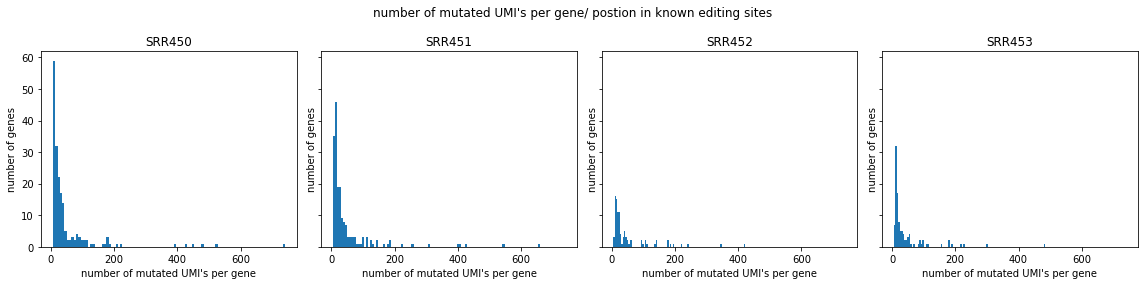

In [34]:
fig, ax = plt.subplots(nrows=1, ncols = 4, sharey=True, sharex=True, figsize=(16,4))

ax[0].hist(clusters_VS_genes_umis_SRR450.sum(),bins = 100)
ax[0].set_title("SRR450")
ax[0].set_xlabel("number of mutated UMI's per gene")
ax[0].set_ylabel("number of genes")

ax[1].hist(clusters_VS_genes_umis_SRR451.sum(),bins = 100)
ax[1].set_title("SRR451")
ax[1].set_xlabel("number of mutated UMI's per gene")
ax[1].set_ylabel("number of genes")

ax[2].hist(clusters_VS_genes_umis_SRR452.sum(),bins = 100)
ax[2].set_title("SRR452")
ax[2].set_xlabel("number of mutated UMI's per gene")
ax[2].set_ylabel("number of genes")

ax[3].hist(clusters_VS_genes_umis_SRR453.sum(),bins = 100)
ax[3].set_title("SRR453")
ax[3].set_xlabel("number of mutated UMI's per gene")
ax[3].set_ylabel("number of genes")


fig.suptitle("number of mutated UMI's per gene/ postion in known editing sites")
plt.tight_layout()
plt.savefig("umi_per_position_in_editing_sites.png")
plt.show()

## Total umi's per barcode

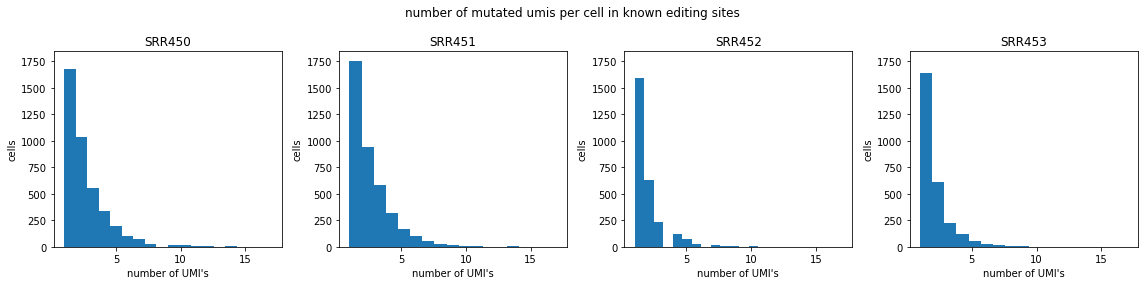

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))

umis_per_cb_editing_450 = df_open_edit_SRR450.groupby('cell barcode')["mutated umis per cell"].sum()
ax[0].hist(umis_per_cb_editing_450, bins = 18)
ax[0].set_title("SRR450")
ax[0].set_xlabel("number of UMI's")
ax[0].set_ylabel("cells")

umis_per_cb_editing_451 = df_open_edit_SRR451.groupby('cell barcode')["mutated umis per cell"].sum()
ax[1].hist(umis_per_cb_editing_451, bins = 16)
ax[1].set_title("SRR451")
ax[1].set_xlabel("number of UMI's")
ax[1].set_ylabel("cells")
ax[1].yaxis.set_tick_params(labelbottom=True)

umis_per_cb_editing_452 = df_open_edit_SRR452.groupby('cell barcode')["mutated umis per cell"].sum()
ax[2].hist(umis_per_cb_editing_452, bins = 15)
ax[2].set_title("SRR452")
ax[2].set_xlabel("number of UMI's")
ax[2].set_ylabel("cells")
ax[2].yaxis.set_tick_params(labelbottom=True)

umis_per_cb_editing_453 = df_open_edit_SRR453.groupby('cell barcode')["mutated umis per cell"].sum()
ax[3].hist(umis_per_cb_editing_453, bins = 16)
ax[3].set_title("SRR453")
ax[3].set_xlabel("number of UMI's")
ax[3].set_ylabel("cells")
ax[3].yaxis.set_tick_params(labelbottom=True)


fig.suptitle("number of mutated umis per cell in known editing sites")
plt.tight_layout()
plt.savefig("umi_per_position_in_editing_sites.png")
plt.show()

## scatter plot - editing events vs. number of mutated umis per cell

In [36]:
# get number of editing sites per cell
editingsites_per_cb_SRR450 = editings_per_cb_SRR450[editings_per_cb_SRR450 >1]
editingsites_per_cb_SRR451 = editings_per_cb_SRR451[editings_per_cb_SRR451 >1]
editingsites_per_cb_SRR452 = editings_per_cb_SRR452[editings_per_cb_SRR452 >1]
editingsites_per_cb_SRR453 = editings_per_cb_SRR453[editings_per_cb_SRR453 >1]

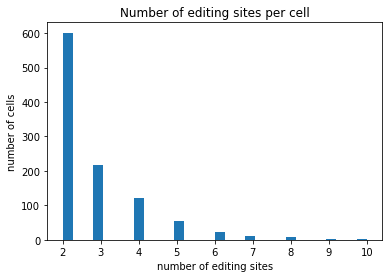

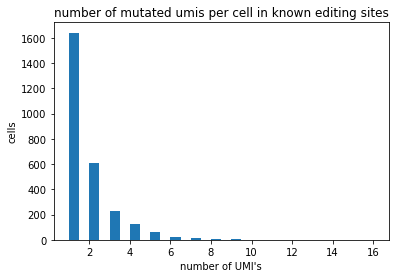

In [37]:
# reminder of histogram from the begginig
plt.hist(editingsites_per_cb_SRR453, bins = 30)
plt.title("Number of editing sites per cell")
plt.xlabel("number of editing sites")
plt.ylabel("number of cells")
plt.show()


plt.hist(umis_per_cb_editing_453, bins = 30)
plt.title("number of mutated umis per cell in known editing sites")
plt.xlabel("number of UMI's")
plt.ylabel("cells")
plt.show()

### Total mutated umis per cell (in BAM file)

In [38]:
editingsites_per_cb_SRR450

cell barcode
AAACCTGAGGGATGGG-1    4
AAACCTGCACGGCTAC-1    3
AAACCTGCAGTATGCT-1    3
AAACCTGTCTTATCTG-1    5
AAACGGGAGGTGATAT-1    4
                     ..
TTTGGTTGTGTCCTCT-1    4
TTTGTCAGTCCGAAGA-1    2
TTTGTCATCCACGACG-1    5
TTTGTCATCTCATTCA-1    2
TTTGTCATCTCTAGGA-1    3
Name: is_edit, Length: 2328, dtype: int64

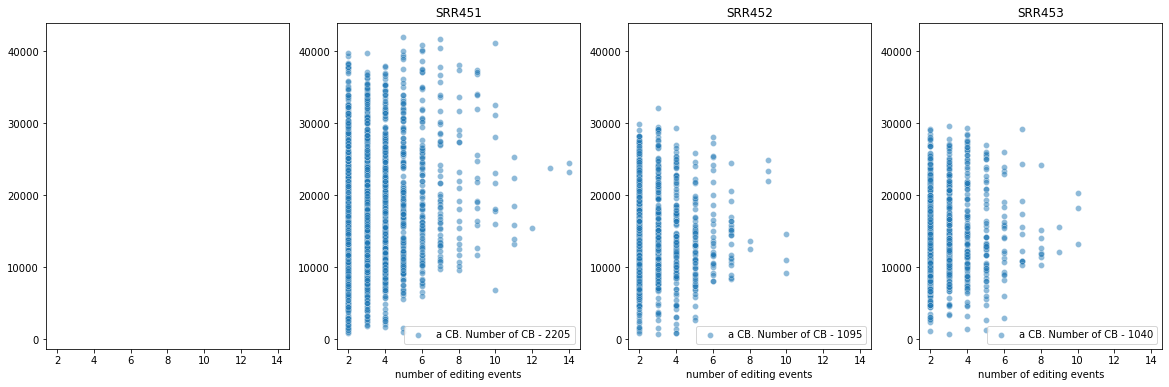

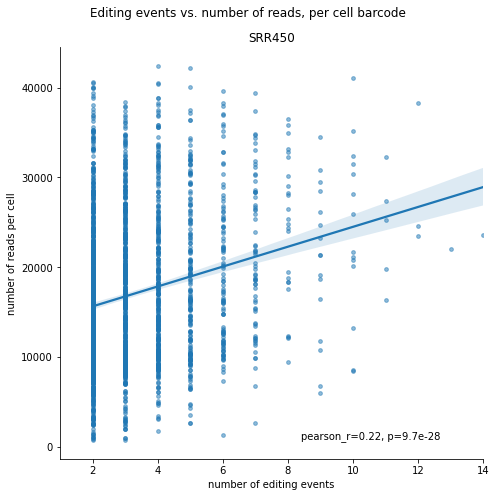

In [89]:
from scipy.stats import pearsonr
# the plot needs to be made from the count of all the umis in cells. this information exist in the bam file before any filtering. 
# in addition, add the column of 0 editing sites (cell barcodes not in the editing table (with the 191 rows)). 
# we want to see if there is correlation between the number of mutated umis per cell and the number of editing sites in the same cell
# If we will see cells which doesn't follow the correlation, will probably have more editing events than usual

def get_reads_per_cell(rpc_fpath):
    """function to read file with counts of reads per cell barcode after parsing. Return dataframe"""
    with open (rpc_fpath, "r") as f:
        reads_per_cb = f.readlines()
    
    df_rpb = {rpc.split()[-1].strip('\n'): rpc.split()[0] for rpc in reads_per_cb}
    df_rpb = pd.DataFrame.from_dict(df_rpb, orient='index',columns = ['number of reads per cell']).reset_index().rename(columns={'index':'cell barcode'})
    df_rpb['cell barcode'] = df_rpb['cell barcode'].map(lambda x: x + '-1')
    df_rpb['number of reads per cell'] = df_rpb['number of reads per cell'].astype('int')
    return df_rpb


fig, ax = plt.subplots(nrows=1, ncols = 4, sharex=True, sharey=True,figsize=(20,6))

# load counts of reads per cell barcode
df_rpb = get_reads_per_cell("/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9450/reads_per_barcode")
df_scatter = pd.merge(editingsites_per_cb_SRR450, df_rpb, on = 'cell barcode')
# sns.lmplot(x='mpg', y='disp', data=df)
s = sns.lmplot(data=df_scatter, x="is_edit", y="number of reads per cell",height=7, scatter_kws={'alpha':0.5, 's':14})
s.set(xlim=(1, None))
# add correlation
def annotate(data, **kws):
    r, p = pearsonr(df_scatter['is_edit'], df_scatter['number of reads per cell'])
    ax = plt.gca()
    ax.text(.9, .05, 'pearson_r={:.2f}, p={:.2g}'.format(r, p),transform=ax.transAxes, ha='right')
    
s.map_dataframe(annotate)

# sns.scatterplot(data=df_scatter, x="is_edit", y="number of reads per cell", alpha = 0.5, ax = ax[0])
plt.title("SRR450")
plt.xlabel('number of editing events')
plt.ylabel('number of reads per cell')
# plt.yaxis.set_tick_params(labelbottom=True)
# plt.legend([f"a CB. Number of CB - {len(df_scatter)}"], loc='lower right')

# load counts of reads per cell barcode
df_rpb = get_reads_per_cell("/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9451/reads_per_barcode")
df_scatter = pd.merge(editingsites_per_cb_SRR451, df_rpb, on = 'cell barcode')
sns.scatterplot(data=df_scatter, x="is_edit", y="number of reads per cell", alpha = 0.5, ax = ax[1])
ax[1].set_title("SRR451")
ax[1].set_xlabel('number of editing events')
ax[1].set_ylabel('number of reads per cell')
ax[1].yaxis.set_tick_params(labelbottom=True)
ax[1].legend([f"a CB. Number of CB - {len(df_scatter)}"], loc='lower right')

# load counts of reads per cell barcode
df_rpb = get_reads_per_cell("/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9452/reads_per_barcode")
df_scatter = pd.merge(editingsites_per_cb_SRR452, df_rpb, on = 'cell barcode')
sns.scatterplot(data=df_scatter, x="is_edit", y="number of reads per cell", alpha = 0.5, ax = ax[2])
ax[2].set_title("SRR452")
ax[2].set_xlabel('number of editing events')
ax[2].set_ylabel('number of reads per cell')
ax[2].yaxis.set_tick_params(labelbottom=True)
ax[2].legend([f"a CB. Number of CB - {len(df_scatter)}"], loc='lower right')

# load counts of reads per cell barcode
df_rpb = get_reads_per_cell("/home/eligol/Documents/01_WIS/scrarevar/data/outputs/statistics_output/human_RSS9453/reads_per_barcode")
df_scatter = pd.merge(editingsites_per_cb_SRR453, df_rpb, on = 'cell barcode')
sns.scatterplot(data=df_scatter, x="is_edit", y="number of reads per cell", alpha = 0.5, ax = ax[3])
ax[3].set_title("SRR453")
ax[3].set_xlabel('number of editing events')
ax[3].set_ylabel('number of reads per cell')
ax[3].yaxis.set_tick_params(labelbottom=True)
ax[3].legend([f"a CB. Number of CB - {len(df_scatter)}"], loc='lower right')

plt.suptitle("Editing events vs. number of reads, per cell barcode")
plt.tight_layout()
plt.savefig("editing_VS_reads_scatter.png")
plt.show()

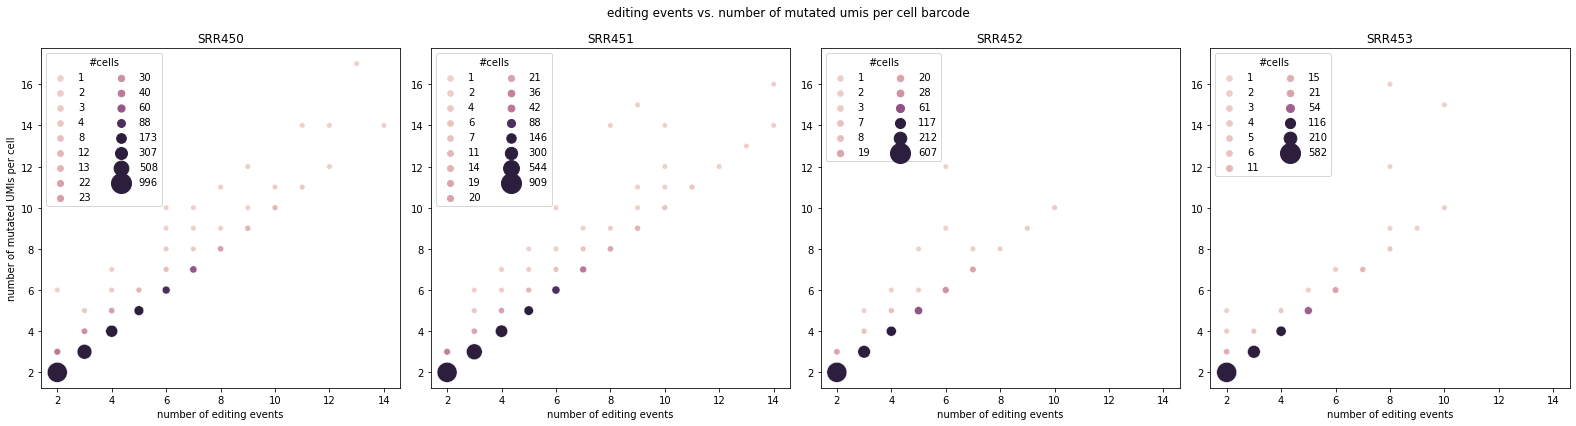

In [82]:
# the plot needs to be made from the count of all the umis in cells. this information exist in the bam file before any filterin. 
# in addition, add the column of 0 editing sites (cell barcodes not in the editing table (with the 191 rows)). 
# we want to see if there is correlation between the number of mutated umis per cell and the number of editing sites in the same cell
# If we will see cells which doesn't follow the correlation, will probably have more editing events than usual

fig, ax = plt.subplots(nrows=1, ncols = 4, sharex=True, sharey=True, figsize=(22,6))

df_scatter = pd.merge(editingsites_per_cb_SRR450, umis_per_cb_editing_450, on = 'cell barcode')
sns.scatterplot(data=df_scatter.groupby(['is_edit','mutated umis per cell']).size().reset_index(name='count of cells'),
                x="is_edit", y="mutated umis per cell", hue="count of cells", size='count of cells',sizes=(30, 400), legend="full",hue_norm=(0, 100), ax=ax[0])
ax[0].set_title("SRR450")
ax[0].set_xlabel('number of editing events')
ax[0].yaxis.set_tick_params(labelbottom=True)
ax[0].set_ylabel('number of mutated UMIs per cell')
ax[0].legend(title='#cells', loc='upper left', ncol=2)

df_scatter = pd.merge(editingsites_per_cb_SRR451, umis_per_cb_editing_451, on = 'cell barcode')
sns.scatterplot(data=df_scatter.groupby(['is_edit','mutated umis per cell']).size().reset_index(name='count of cells'),
                x="is_edit", y="mutated umis per cell", hue="count of cells", size='count of cells',sizes=(30, 400), legend="full",hue_norm=(0, 100), ax=ax[1])
ax[1].set_title("SRR451")
ax[1].set_xlabel('number of editing events')
ax[1].yaxis.set_tick_params(labelbottom=True)
ax[1].set_ylabel('number of mutated UMIs per cell')
ax[1].legend(title='#cells',loc='upper left', ncol=2)


df_scatter = pd.merge(editingsites_per_cb_SRR452, umis_per_cb_editing_452, on = 'cell barcode')
sns.scatterplot(data=df_scatter.groupby(['is_edit','mutated umis per cell']).size().reset_index(name='count of cells'),
                x="is_edit", y="mutated umis per cell", hue="count of cells", size='count of cells',sizes=(30, 400), legend="full",hue_norm=(0, 100), ax=ax[2])
ax[2].set_title("SRR452")
ax[2].set_xlabel('number of editing events')
ax[2].yaxis.set_tick_params(labelbottom=True)
ax[2].set_ylabel('number of mutated UMIs per cell')
ax[2].legend(title='#cells',loc='upper left', ncol=2)


df_scatter = pd.merge(editingsites_per_cb_SRR453, umis_per_cb_editing_453, on = 'cell barcode')
sns.scatterplot(data=df_scatter.groupby(['is_edit','mutated umis per cell']).size().reset_index(name='count of cells'),
                x="is_edit", y="mutated umis per cell", hue="count of cells", size='count of cells',sizes=(30, 400), legend="full",hue_norm=(0, 100), ax=ax[3])
ax[3].set_title("SRR453")
ax[3].set_xlabel('number of editing events')
ax[3].yaxis.set_tick_params(labelbottom=True)
ax[3].set_ylabel('number of mutated UMIs per cell')
ax[3].legend(title='#cells',loc='upper left', ncol=2)


plt.suptitle("Editing events vs. number of mutated umis per cell barcode")
plt.tight_layout()
plt.savefig("editing_VS_umi_scatter.png")
plt.show()

## Data of editing sites positions - Histograms and boxplots

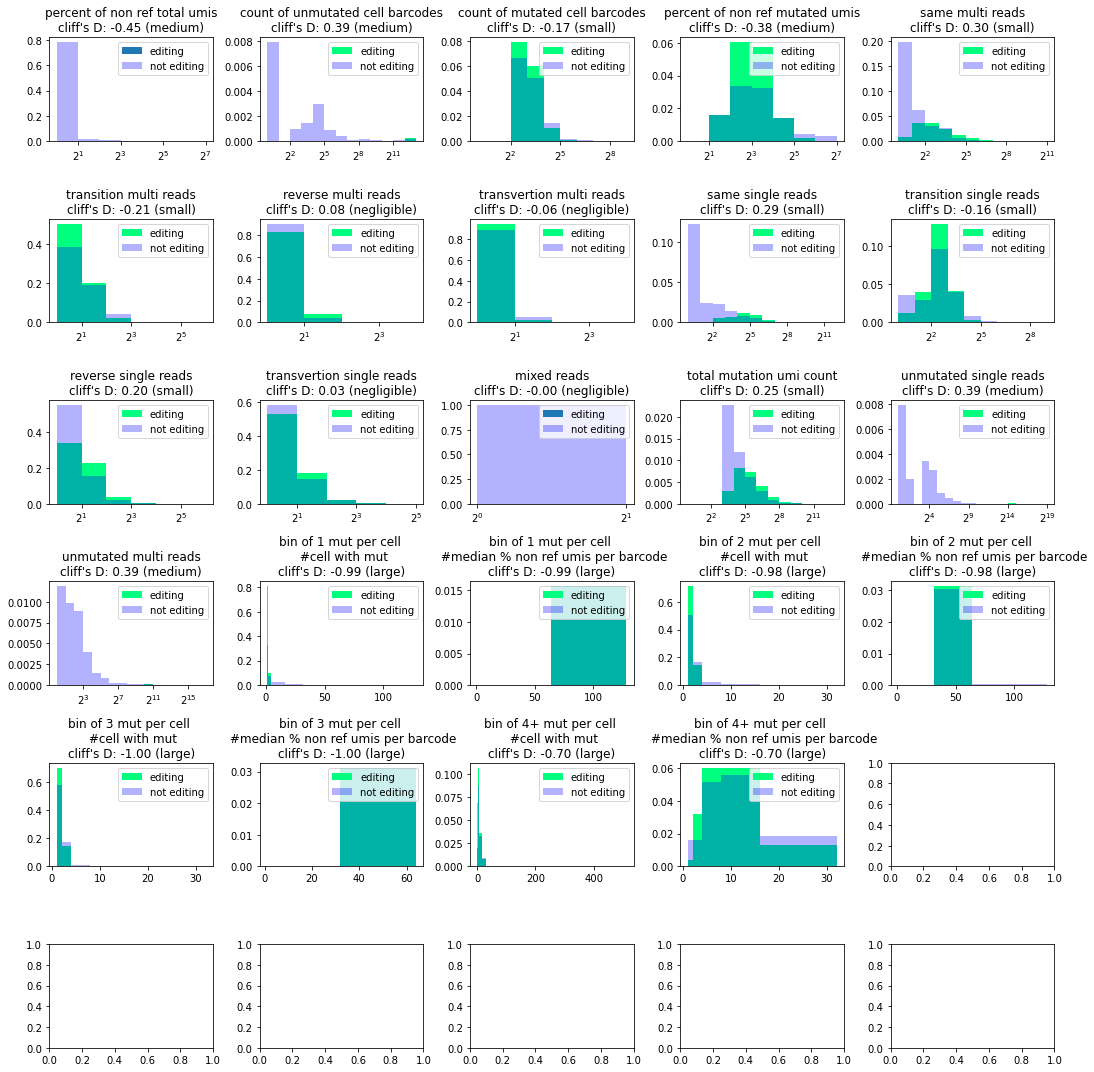

In [25]:
plot_histograms(df_edit, df_non_edit, ['editing', 'not editing'])

# plot boxplots

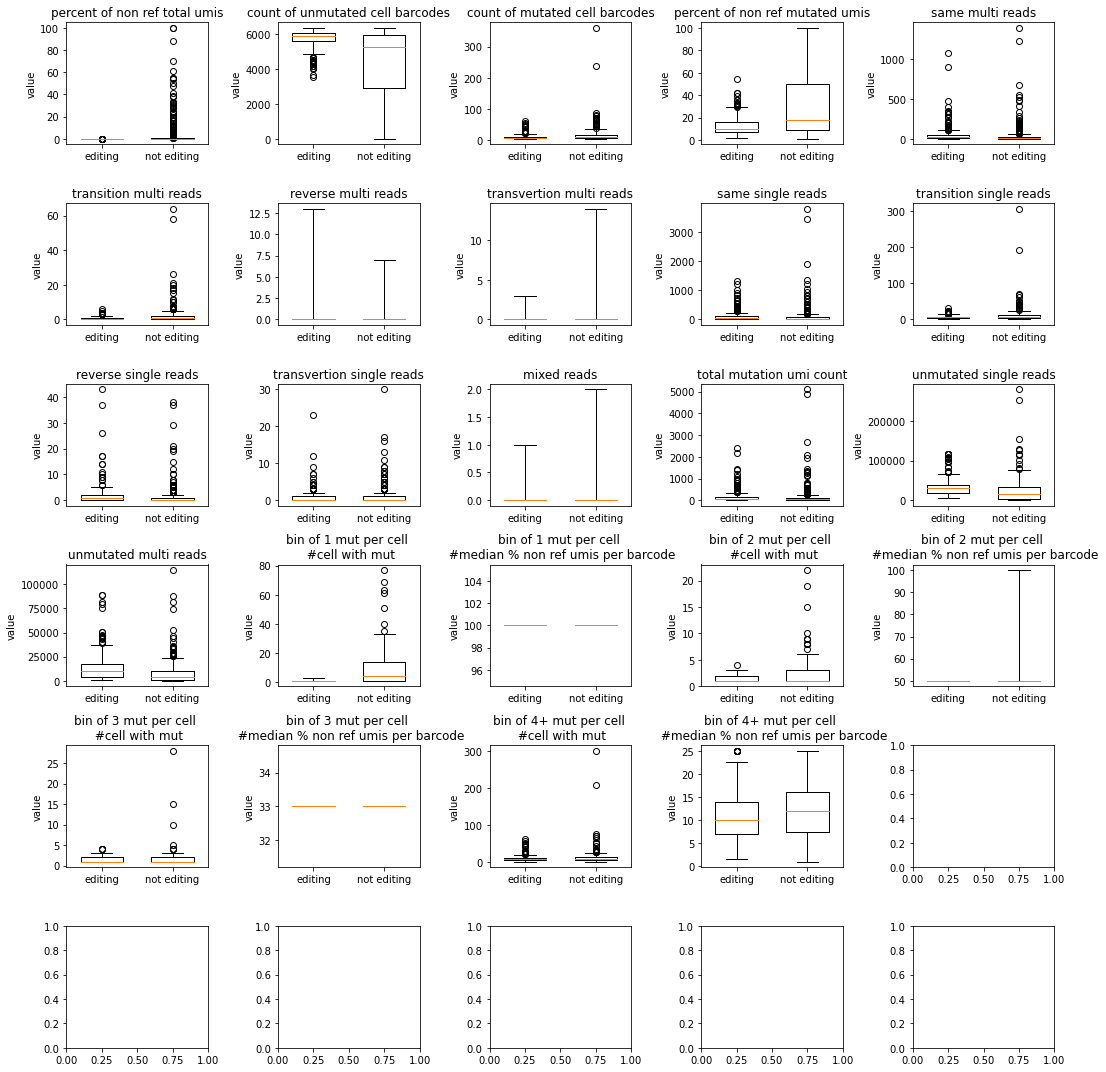

In [26]:
plot_boxplots(df_edit, df_non_edit, ['editing', 'not editing'])
# plot_boxplots(df.loc[(df['is_editing_rep']==1) | (df['is_editing_non_rep']==1),:], df.loc[df['is_snp']==1,:] , ['editing', 'snp'])

## UMAP

In [27]:
import umap

reducer = umap.UMAP(low_memory=True)
embedding = reducer.fit_transform(data)
plot_title = 'UMAP'

# Classification tasks

## Define parameters and dataset for model training

In [4]:
WITH_REF_COLS = True  #flag to keep ref base columns
TO_SCALE = False# flag to scale the data
non_ref_percent_snp_thresh = 10  # threshol for column 'perent of non ref total reads' for more confident snp sites 

## SNP soft classifier

In [116]:
def make_numeric_df(df):
    """function to return df and df with only numeric data"""
    #drop string unrelevant for trainig data
    df_numeric = df.drop(['#chromosome','start','end','reference base','position',  
                                      'strand','aggregated cell barcodes'], axis = 1)
    
    if TO_SCALE:  # scale the df (not binary reference base columns)
        df_numeric = pd.DataFrame(StandardScaler().fit_transform(df_numeric),  
                                        index = df_numeric.index, columns = df_numeric.columns)
        
    if WITH_REF_COLS:  # convert ref columns to dummies and add to ddf
        # get dummies for reference bases
        dummies = pd.get_dummies(df['reference base'],prefix = 'refbase')
        # concat scaled df and dummies columns
        df_numeric = pd.concat([df_numeric,dummies], join = 'inner',axis = 1)
    return df, df_numeric


def set_snp_thresh(df, non_ref_percent_snp_thresh):
    """Add snp threshold for more confidence. First notate snps with more than 10% non ref total reads. 
    These are sites we can be more confident for beeing snp, rather than less than 10% of non ref mutation
    """
    df['is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)] = 0  #initialize column
    idx_snp_gt_X = df[(df['is_snp'] == 1) & (df['percent of non ref total umis'] >= non_ref_percent_snp_thresh)].index #find the sites with more tahn 10% mutation
    df.loc[idx_snp_gt_X, 'is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)] = 1  # assign to columns
    return df

def get_model_data(df,non_ref_percent_snp_thresh):
    """make data ready for trining."""
    # return data in numeric form snp threshold for more confidence
    df = set_snp_thresh(df, non_ref_percent_snp_thresh)
    
    # make numeric df for trainig
    df, df_numeric = make_numeric_df(df)
    
    # make the X features
    X = df_numeric.drop(['is_snp','is_editing_rep','is_editing_non_rep','is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)],axis=1)  # set X to be all the mutation data

    # make label column
    y = df['is_snp_umi_mut_gt_{}'.format(non_ref_percent_snp_thresh)]

    print("y counts:")
    print(y.value_counts())
    print()
    return X, y
    
    
def train_cv_snp_clf(df, model, non_ref_percent_snp_thresh):
    X, y = get_model_data(df, non_ref_percent_snp_thresh)
    scores = cross_validate(model, X, y,scoring='roc_auc',n_jobs = -1, cv=5, return_train_score=True)
    print("SNP classifier cross validation TEST scores with non_ref_percent_snp_thresh of {}".format(non_ref_percent_snp_thresh), scores['test_score'])
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores['test_score'].mean(), scores['test_score'].std()))
    print("SNP classifier cross validation TRAIN scores with non_ref_percent_snp_thresh of {}".format(non_ref_percent_snp_thresh), scores['train_score'])
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores['train_score'].mean(), scores['train_score'].std()))

### search the best non_ref_percent_snp_thresh

In [ ]:
# find the best snp filter threshold

model = XGBClassifier(n_jobs=-1,random_state=123)

for snp_non_ref_thresh in [0,30,40,50]:
    print("\n####")
    print("snp_non_ref_thresh is: ",snp_non_ref_thresh)
    train_cv_snp_clf(df, model, snp_non_ref_thresh)
    df = df.drop('is_snp_umi_mut_gt_{}'.format(snp_non_ref_thresh), axis=1)

### Build a model with the best snp_non_ref threshold

In [ ]:
X, y = get_model_data(df, 40)
#split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
# train and analyze
ROC_multiple_models(models, X_train, y_train,X_test, y_test)
# this is currently the best modelafter after parameter random search
model = XGBClassifiermodel = XGBClassifier(n_jobs=-1,random_state=123,verbosity=0)

model.fit(X_train, y_train) # fit the model to the data
evaluate_model(model, X_train, X_test, y_test, y_train)

## Analyze the mistake instances -

In [ ]:
# look into the test set
y_pred = model.predict(X_test)
true_values = y_test
predicted_values = y_pred

idx = X_test[(true_values == 1) & (predicted_values == 0)].index
X_test.loc[idx,:]  #normalizes
df.loc[idx,:]  # original

# SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[1,:])

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot("percent of non ref total umis", shap_values, X_test, interaction_index="refbase_a")

In [ ]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

## Save trained model weights to file

In [ ]:
# Initialize the best model after after parameter fine tuning
moedl = XGBClassifier(n_estimators=100, objective='binary:logistic',n_jobs=-1, subsample= 0.8, random_state=123,
                      reg_lambda= 0.0001, reg_alpha= 0.0001, min_child_weight= 5, max_depth= 4, 
                      learning_rate= 0.1, gamma= 0.1, colsample_bytree= 1.0)

# retrain on all the data (no train test split) 
model.fit(X, y) # fit the model to the data
# evaluate_model(model, X, X, y, y)

# save the model to file for use in pipeline
dump(model, '/home/eligol/Documents/01_WIS/scrarevar/data/trained_models/snp_classifier.joblib') 

### load the model and make predictions on new data

In [ ]:
!python /home/eligol/Documents/01_WIS/scrarevar/code/scRNAvariants/scripts/filter_snp.py 

## XGBoost parameter random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate':[0.01, 0.1, 1],
        'reg_alpha' : [0, 1e-2,1e-3,1e-4,1e-5],
        'reg_lambda' : [0, 1e-2,1e-3,1e-4,1e-5]
        }
xgb = XGBClassifier(learning_rate=0.1, n_estimators=500, objective='binary:logistic',n_jobs=-1,)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1001 )
random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

In [ ]:
evaluate_model(random_search.best_estimator_, X_train, X_test, y_test, y_train)

# Classification - editing

In [ ]:
def make_numeric_edit_df(df):
    """function to return df and df with only numeric data"""
    #drop string unrelevant for trainig data
    df_numeric = df.drop(['#chromosome','start','end','position', 'reference base',
                                      'strand','aggregated cell barcodes', 'mixed reads', 'percent of non ref mutated umis', 'total mutation umi count'], axis = 1)
    
    if TO_SCALE:  # scale the df (not binary reference base columns)
        df_numeric = pd.DataFrame(StandardScaler().fit_transform(df_numeric),  
                                        index = df_numeric.index, columns = df_numeric.columns)
        
    if WITH_REF_COLS:  # convert ref columns to dummies and add to ddf
        # get dummies for reference bases
        dummies = pd.get_dummies(df['reference base'],prefix = 'refbase')
        # concat scaled df and dummies columns
        df_numeric = pd.concat([df_numeric,dummies], join = 'inner',axis = 1)
    return df, df_numeric

WITH_REF_COLS = False

# drop known snp sites
df_edit = df.copy()
df_edit = df_edit[df_edit['is_snp'] != 1]
# df_edit = df_edit[df_edit['reference base'] == 'a'].copy()

y = df_edit['is_editing_rep'].combine(df_edit['is_editing_non_rep'], max)

# df_edit.drop(['is_snp','is_editing_rep','is_editing_non_rep','is_snp_umi_mut_gt_0'],axis=1,inplace=True)
df_edit.drop(['is_snp','is_editing_rep','is_editing_non_rep'],axis=1,inplace=True)
df_edit, df_numeric = make_numeric_edit_df(df_edit)


In [ ]:
X = df_numeric
y.value_counts()

In [ ]:
# over sampling
# ros = RandomOverSampler(sampling_strategy=1,random_state=0,shrinkage=0)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# down sampling
ros = RandomUnderSampler(random_state=0,sampling_strategy=1)
X_resampled, y_resampled = ros.fit_resample(X, y)

X=X_resampled
y=y_resampled

y.value_counts()

In [ ]:
model_xgb = XGBClassifier(n_estimators=100,random_state=888, n_jobs=-1)
model = model_xgb


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
model.fit(X_train, y_train) # fit the model to the data. This is essencially the 'learning'

In [ ]:
# train and evaluate
ROC_multiple_models(models, X_train,y_train,X_test,y_test)
evaluate_model(model, X_train, X_test, y_test, y_train)

In [ ]:
X_test

In [ ]:
# look into the test set
y_pred = model.predict(X)
true_values = y
predicted_values = y_pred

idx = X[(true_values == 1) & (predicted_values == 1)].index
X.loc[idx,:]  #normalizes
# df.loc[idx,:]  # original

In [ ]:
X_t = X.loc[idx,:].loc[(X['percent of non ref total umis'] < 1),:]
X_t

In [ ]:
X[y==1]
X

In [ ]:
plot_histograms(X[y==1].loc[X['percent of non ref total umis'] > 1,:], X[y==0].iloc[:400,:] , ['editing', 'not editing'])

## train two datasets

In [ ]:
# set test set
df_test = embryo_df

snp_df_test = df_test[df_test['is_snp'] == 1]  #create separate df_test for SNP
pos_df_test = df_test[(df_test['is_editing_rep'] == 1) | (df_test['is_editing_non_rep'] == 1)]  # set editing sites as positive label
neg_df_test = df_test[(df_test['is_editing_rep'] != 1) & (df_test['is_editing_non_rep'] != 1) & (df_test['is_snp'] != 1)]  # otherwise set as negative label

# set the labels for all samples in df_test
df_test.loc[snp_df_test.index, 'label'] = 2
df_test.loc[pos_df_test.index, 'label'] = 1
df_test.loc[neg_df_test.index, 'label'] = 0

df_test = df_test  # set df_test to analyze
#drop unused columns
df_test_numeric = df_test.drop(['#chromosome','start','end','reference base','position',  
                                  'strand','aggregated cell barcodes','is_snp','is_editing_rep',
                                  'is_editing_non_rep','label'], axis = 1)
# get dummies for reference bases
dummies = pd.get_dummies(df_test['reference base'],prefix = 'refbase')
# scale the df_test (not binary reference base columns)
# df_test_numeric = pd.DataFrame(StandardScaler().fit_transform(df_test_numeric),  
#                                 index = df_test_numeric.index, columns = df_test_numeric.columns)
# concat scaled df_test and dummies columns
df_test_numeric = pd.concat([df_test_numeric,dummies], join = 'inner',axis = 1)
df_test_numeric

In [ ]:
# prepare the data
X_test = df_test_numeric  # set X to be all the mutation data
y_test = df_test['label'].copy()
y_test[pos_df_test.index] = 0 #0 labels are non editing + editing sites
y_test[snp_df_test.index] = 1 #1 labels are snp

In [ ]:
y.value_counts()

In [ ]:
model = model_xgb  # choose one model
model.fit(X, y) # fit the model to the data. This is essencially the 'learning'

evaluate_model(model, X, X_test, y_test, y)


In [ ]:
model.estimators_.shape

In [ ]:
model.get_booster()

## PCA

In [ ]:

df, df_numeric =  make_numeric_df(df)


In [ ]:
pca_labels = df['is_snp'].copy()
pca_labels[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)] = 2
pca_labels.name = 'label'

In [ ]:
df_numeric.head(3)

In [ ]:
temp_df = df_numeric[['percent of non ref total umis', 'percent of non ref mutated umis','total mutation umi count','unmutated single reads','unmutated multi reads']]
temp_df = df_numeric[['refbase_a','refbase_c','refbase_g','refbase_t', 'same multi reads','transition multi reads','reverse multi reads','transvertion multi reads','same single reads','transition single reads','reverse single reads','transvertion single reads']]


In [ ]:
from sklearn.decomposition import PCA
data = temp_df

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pca_labels.reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color, alpha = 0.3
               , s = 50)
ax.legend(targets)
ax.grid()
print("PC explained variance:",pca.explained_variance_ratio_)
plt.show()

# Histogram A for Dena - 

In [ ]:
"""
this histogram is hist A for Dena. 
First, we calculated the fraction of cells with modification out of all the cells in this position. 
Next we choose all the positions with overlap with the editing database and plot a histogram for these fraction values.
"""
def Dena_hist1(df):
    # add to aggregated file a column with fraction of mutated cells out of total number of cells in a postoin 
    df['percent of mutated cells'] = df['count of mutated cell barcodes'] / (df['count of mutated cell barcodes'] + df['count of unmutated cell barcodes']) * 100
    df_edit = df[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)] 

    plt.title("fraction of cells with modification within each position")
    plt.xlabel("fraction %")
    plt.ylabel("counts of positions")
    plt.hist(df_edit['percent of mutated cells'],bins=30)
    plt.hist(df['percent of mutated cells'],bins=30,histtype='step')
    plt.show()

In [ ]:
"""
this histogram is hist A for Dena. 
First, we calculated the fraction of cells with modification out of all the cells in this position. 
Next we choose all the positions with overlap with the editing database and plot a histogram for these fraction values.
"""
def Dena_hist1(df):
    # add to aggregated file a column with fraction of mutated cells out of total number of cells in a postoin 
    df['percent of mutated cells'] = df['count of mutated cell barcodes'] / (df['count of mutated cell barcodes'] + df['count of unmutated cell barcodes']) * 100
    df_edit = df[(df['is_editing_rep'] == 1) | (df['is_editing_non_rep'] == 1)] 

    plt.title("fraction of cells with modification within each position")
    plt.xlabel("fraction %")
    plt.ylabel("counts of positions")
    plt.hist(df_edit['percent of mutated cells'],bins=30)
    plt.hist(df['percent of mutated cells'],bins=30,histtype='step')
    plt.show()

In [ ]:
Dena_hist1(adipose_df)

# Hist B for Dena - Analyse data table in open form

In [ ]:
def Dena_histb(df_open, df_agg):
    print("df_open original shape:", df_open.shape)
    # merge with agg df and transfer the edit-snp flags. The output shape is as df_open. Note that agg_df might be already filtered.
    df_open = df_open.merge(df_agg[['position','is_snp','is_editing_rep','is_editing_non_rep']],on = 'position')
    print("df_open shape after merge:", df_open.shape)
    # make subset of editing sites
    df_open_edit = df_open[(df_open['is_editing_rep'] == 1) | (df_open['is_editing_non_rep'] == 1)]  # set editing sites as positive label
    print("df_open only editing sites:", df_open_edit.shape)
    
    df_open_edit_gt1 = df_open_edit[df_open_edit['total umi count'] > 1]

    # look at UMI's fraction - mean and std for all cells within each position
    col = 'percent of non ref'
    df_grouped = df_open_edit_gt1.groupby(['position'])
    df_grouped_mean_std = pd.DataFrame(df_grouped.groups.keys(), columns = ['position'])
    df_grouped_mean_std['mean {}'.format(col)] = df_grouped[col].median().values
    df_grouped_mean_std['std {}'.format(col)] = df_grouped[col].std().values
    df_grouped_mean_std['number of cells with more than 1 UMI'] = df_grouped[col].count().values
    df_agg_extand = df_agg.merge(df_grouped_mean_std,on = 'position')
    
    # plot
    plt.hist(df_grouped_mean_std['mean percent of non ref'], bins = 20)
    plt.show()

In [ ]:
df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_RSS9451/merged_mutated_unmutated_no_agg.tsv", sep='\t')
Dena_histb(df_open, embryo_df)

In [ ]:
df_open = pd.read_csv("/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_adipose/from_wexac/merged_mutated_unmutated_no_agg.tsv", sep='\t')
Dena_histb(df_open, adipose_df)

In [ ]:
df_open[df_open['position'] == 'chr10:1000771-1000772,+']
df_grouped_mean_std
df_open_edit['position'].nunique()
df_open.shape

In [ ]:
df_open_edit_gt1 = df_open_edit[df_open_edit['total umi count'] >= 0]
col = 'percent of non ref'
df_grouped = df_open_edit_gt1.groupby(['position'])
df_grouped_mean_std = pd.DataFrame(df_grouped.groups.keys(), columns = ['position'])
df_grouped_mean_std['mean {}'.format(col)] = df_grouped[col].median().values
df_grouped_mean_std['std {}'.format(col)] = df_grouped[col].std().values
df_grouped_mean_std['number of cells with more than 1 UMI'] = df_grouped[col].count().values
df_agg_extand = embryo_df.merge(df_grouped_mean_std,on = 'position')

In [ ]:
df_agg_extand

In [ ]:
(df_open.groupby(['position']).filter(lambda x: x['cell barcode'].count() == 5))

In [ ]:
pd.read_csv('/home/eligol/Documents/01_WIS/01_Rarevar/outputs/statistics_output/human_SRR9451/aggregated_tsv.tsv',sep = '\t')

In [ ]:
t[t != 0]

In [36]:
# add column of mean and std of all cell barcodes in each position
cols = [col for col in embryo_df.columns if col.startswith("R->")]
cols = cols + ['total umi count']
df_grouped = df_open.groupby('position')
df_temp = pd.DataFrame(df_grouped.groups.keys(),columns = ['position'])
for col in cols:
    df_temp['mean {}'.format(col)] = df_grouped[col].mean().values
    df_temp['std {}'.format(col)] = df_grouped[col].std().values
df_agg_extand = embryo_df.merge(df_temp,on = 'position')

# # add edit and snp notation to df (not aggregated)
# for col in ['is_snp', 'is_editing_rep', 'is_editing_non_rep']:
#     positions = df_agg_extand.loc[df_agg_extand[col] == 1, 'position'].values
#     df[col] = 0
#     df.loc[df['position'].isin(positions), col] = 1


## K-means

In [ ]:
#KMEANS
kmeans = KMeans(n_clusters=2, n_init = 100, max_iter = 10000)
t = kmeans.fit_predict(df_numeric)

confusion_matrix(df['label'].values,t)

## PCA

In [ ]:
from sklearn.decomposition import PCA
data = df_numeric

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['label']].reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color, alpha = 0.3
               , s = 50)
ax.legend(targets)
ax.grid()
print("PC explained variance:",pca.explained_variance_ratio_)
plt.show()

# TSNE

In [7]:
# set data to analyze - all numeric data
X = df_numeric

# run TSNE on all numeric data 
tsne = TSNE(n_components = 2,n_jobs=-1,perplexity = 30)
X_embedded = tsne.fit_transform(X)

In [8]:
X_embedded.shape

(108700, 2)

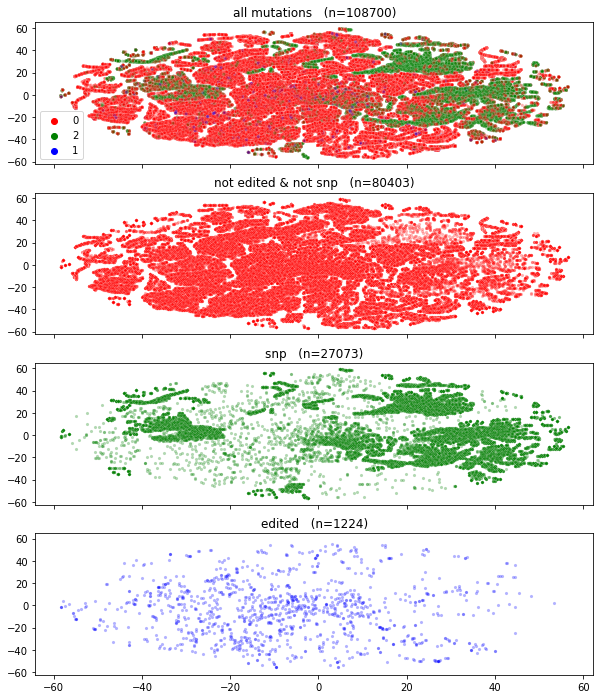

In [9]:
# plot TSNE 
y = df[['label']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 12),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],s=10,alpha = 0.3,palette=['red','green','blue'],hue=y,hue_order=[0,2,1],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded[y==0,0], y=X_embedded[y==0,1],s=10,alpha = 0.3 ,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("not edited & not snp   (n={})".format(str((y==0).sum())))
sns.scatterplot(x=X_embedded[y==2,0], y=X_embedded[y==2,1],s=10,alpha = 0.3, color = 'green', legend='full',ax=axs[2])
axs[2].set_title("snp   (n={})".format(str((y==2).sum())))
sns.scatterplot(x=X_embedded[y==1,0], y=X_embedded[y==1,1],s=10,alpha = 0.3, color = 'blue', legend='full',ax=axs[3])
axs[3].set_title("edited   (n={})".format(str((y==1).sum())))
plt.show()

#### plot TSNE - all numeric data by ref bases

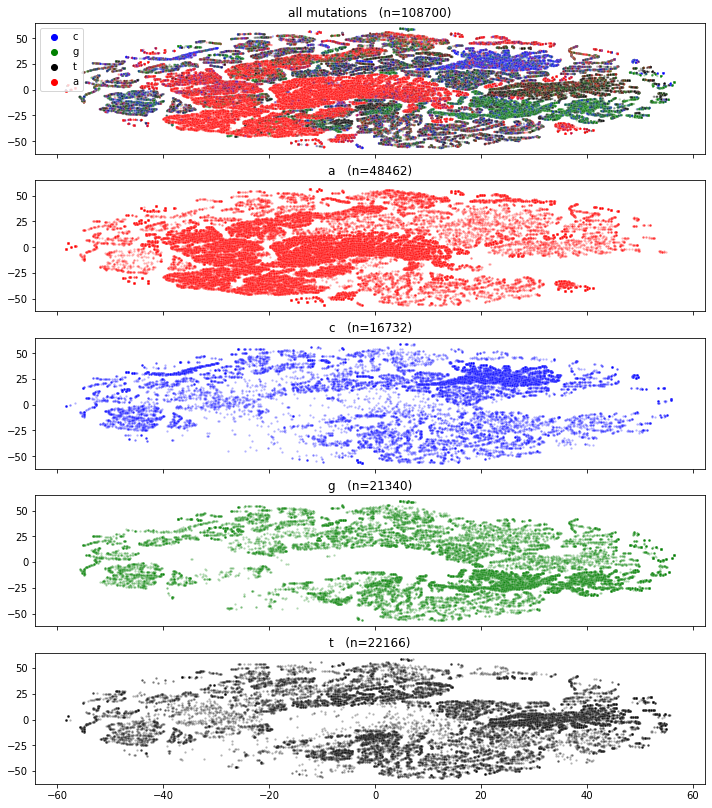

In [10]:
y = df[['reference base']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],s =5,alpha = 0.3,hue=y,palette=['blue','green','black','red'],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded[y=='a',0], y=X_embedded[y=='a',1],s=5,alpha = 0.3,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("a   (n={})".format(str((y=='a').sum())))
sns.scatterplot(x=X_embedded[y=='c',0], y=X_embedded[y=='c',1],s=5,alpha = 0.3, color = 'blue', legend='full',ax=axs[2])
axs[2].set_title("c   (n={})".format(str((y=='c').sum())))
sns.scatterplot(x=X_embedded[y=='g',0], y=X_embedded[y=='g',1],s=5,alpha = 0.3, color = 'green', legend='full',ax=axs[3])
axs[3].set_title("g   (n={})".format(str((y=='g').sum())))
sns.scatterplot(x=X_embedded[y=='t',0], y=X_embedded[y=='t',1],s=5,alpha = 0.3, color = 'black', legend='full',ax=axs[4])
axs[4].set_title("t   (n={})".format(str((y=='t').sum())))
plt.show()

## TSNE by ref after removing refbases

In [11]:
# set data to analyze - all numeric data without refbases
X = df_numeric.drop(['refbase_a','refbase_c','refbase_g','refbase_t'],axis=1)

# run TSNE
tsne = TSNE(n_components = 2,perplexity = 30,n_jobs=-1)
X_embedded_by_refbase = tsne.fit_transform(X)

In [ ]:
# plot TSNE by ref bases
y = df[['reference base']].values.reshape((df.shape[0],))

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 14),sharex=True, sharey=True)
axs = axs.reshape(-1)

sns.scatterplot(x=X_embedded_by_refbase[:,0], y=X_embedded_by_refbase[:,1],s =5,alpha = 0.3,hue=y,palette=['blue','green','black','red'],ax=axs[0])
axs[0].set_title("all mutations   (n={})".format(str(len(y))))
sns.scatterplot(x=X_embedded_by_refbase[y=='a',0], y=X_embedded_by_refbase[y=='a',1],s=5,alpha = 0.3,color = 'red', legend='full',ax=axs[1])
axs[1].set_title("a   (n={})".format(str((y=='a').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='c',0], y=X_embedded_by_refbase[y=='c',1],s=5,alpha = 0.3, color = 'blue', legend='full',ax=axs[2])
axs[2].set_title("c   (n={})".format(str((y=='c').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='g',0], y=X_embedded_by_refbase[y=='g',1],s=5,alpha = 0.3, color = 'green', legend='full',ax=axs[3])
axs[3].set_title("g   (n={})".format(str((y=='g').sum())))
sns.scatterplot(x=X_embedded_by_refbase[y=='t',0], y=X_embedded_by_refbase[y=='t',1],s=5,alpha = 0.3, color = 'black', legend='full',ax=axs[4])
axs[4].set_title("t   (n={})".format(str((y=='t').sum())))
plt.show()